# Mitigating edge effects in paleoclimate reconstructions: a comprehensive review and bias assessment of soil brGDGT-based temperature reconstructions
**Author**: Jie Liang¹²*, Xianwei Liu³, Amedea Perfumo¹⁴*, Lichen Yang⁵, Juzhi Hou², Haichao Xie²*, Ulrike Herzschuh¹⁶⁷*, Fahu Chen²

---

### Article Information 

**Published in**:  

**Affiliations**:  

¹ Polar Terrestrial Environmental Systems, Alfred Wegener Institute Helmholtz Centre for Polar and Marine Research, Telegrafenberg, 14473 Potsdam, Germany  

² Group of Alpine Paleoecology and Human Adaptation (ALPHA), State Key Laboratory of Tibetan Plateau Earth System, Resources and Environment (TPESRE), Institute of Tibetan Plateau Research, Chinese Academy of Sciences, 100101 Beijing, China  

³ Helmholtz Centre Potsdam GFZ German Research Centre for Geosciences, Telegrafenberg, 14473 Potsdam, Germany  

⁴ Chrono-Environnement UMR6249, CNRS, Université Marie et Louis Pasteur, F-25000 Besançon, France

⁵ Department of Mathematics, Northeastern University, 02115 Boston, United States  

⁶ Institute of Environmental Science and Geography, University of Potsdam, 14469 Potsdam, Germany  

⁷ Institute of Biochemistry and Biology, University of Potsdam, 14476 Potsdam, Germany  


---
### Notebook Overview  

- Reproduce the key results from the paper.  
- Provide a clear, step-by-step explanation of the data processing and analysis.  
- Visualize and interpret the results supporting this study.  
---



# Fig. 1 BrGDGT weighted temperature bias mapping

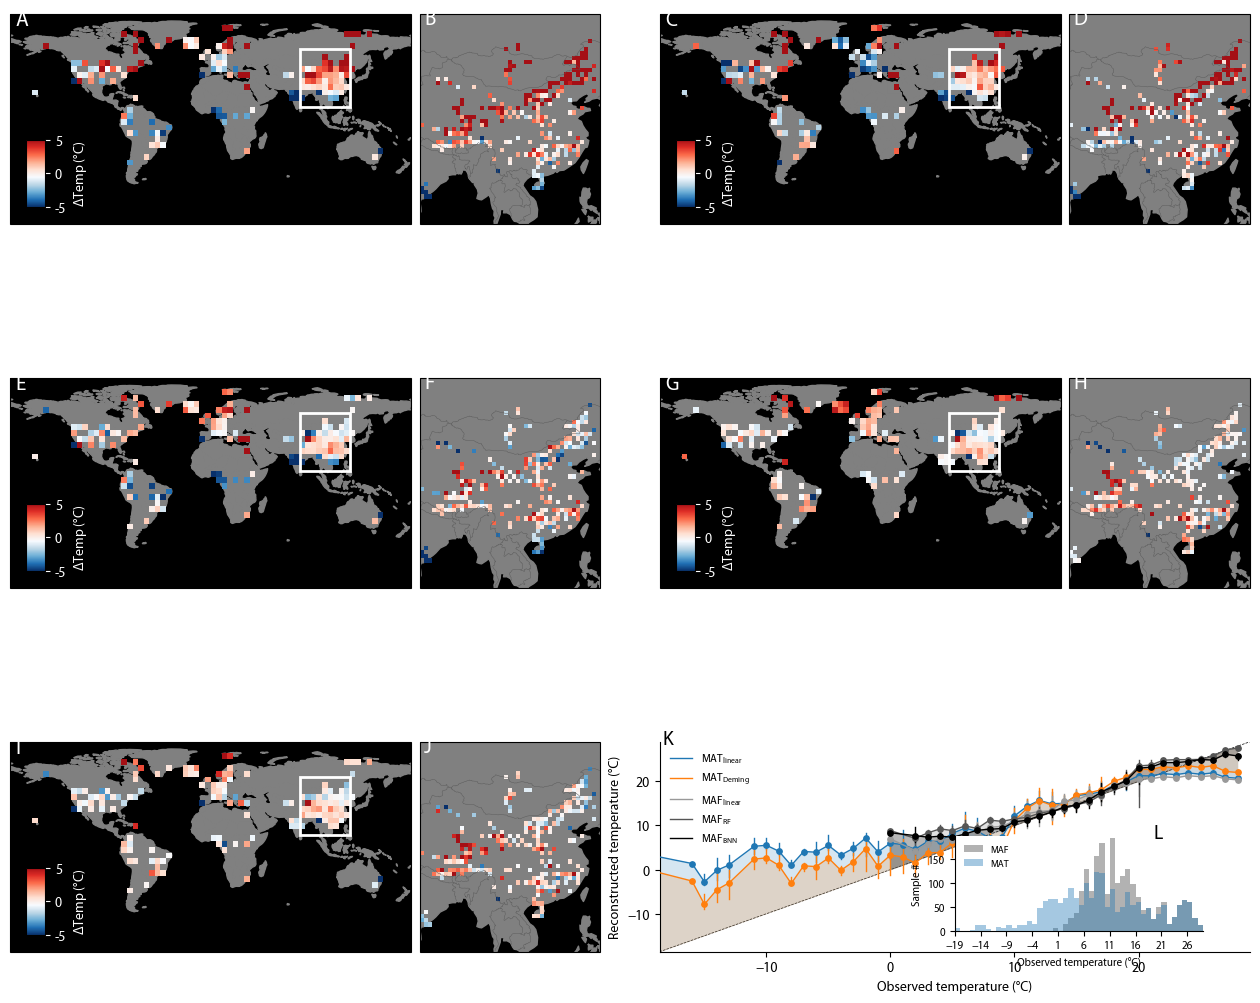

In [11]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
import cartopy.crs as ccrs
from cartopy.feature import BORDERS
from shapely.geometry import Polygon, box
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import matplotlib.font_manager as fm


font_path = r"C:\Users\jie liang\Downloads\Myriad Pro Regular\Myriad Pro Regular.ttf"
fm.fontManager.addfont(font_path)


mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Myriad Pro'
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Myriad Pro'


xls_map = pd.ExcelFile(
    "C:/Users/jie liang/gloabl soil brGDGT dataset - v2.xlsx"
)
df_check = pd.read_excel(xls_map, ' Temperature_Comparison')
df_map = pd.DataFrame(df_check)

def convert_to_grid(df, cell_size):
    df['grid_lon'] = (df["longitude(°E)"] // cell_size) * cell_size
    df['grid_lat'] = (df["latitude(°N)"] // cell_size) * cell_size
    return df

def make_grid(df, cell_size, value_col):
    df = convert_to_grid(df.copy(), cell_size)
    df['weight'] = 1 / (1 + abs(df[value_col]))
    weighted_avg = df.groupby(['grid_lon', 'grid_lat']).apply(
        lambda x: (x[value_col] * x['weight']).sum() / x['weight'].sum()
    ).reset_index(name='weighted_delta')

    grid_polygons = [
        Polygon([
            (row['grid_lon'], row['grid_lat']),
            (row['grid_lon'] + cell_size, row['grid_lat']),
            (row['grid_lon'] + cell_size, row['grid_lat'] + cell_size),
            (row['grid_lon'], row['grid_lat'] + cell_size)
        ])
        for _, row in weighted_avg.iterrows()
    ]

    grid = gpd.GeoDataFrame(
        {
            'geometry': grid_polygons,
            'weighted_delta': weighted_avg['weighted_delta']
        },
        crs="EPSG:4326"
    )
    return grid

cell_size_1 = 5
cell_size_2 = 1

# A/B：deltaMAT-MATdeJonge
grid_1_dejonge = make_grid(df_map, cell_size_1, 'deltaMAT-MATdeJonge')
grid_2_dejonge = make_grid(df_map, cell_size_2, 'deltaMAT-MATdeJonge')

# C/D：deltaMAT-MATsoilNaaf
grid_1_naaf = make_grid(df_map, cell_size_1, 'deltaMAT-MATsoilNaaf')
grid_2_naaf = make_grid(df_map, cell_size_2, 'deltaMAT-MATsoilNaaf')

# E/F：deltaMAF-WC_LINEAR
grid_1_linear = make_grid(df_map, cell_size_1, 'deltaMAF-WC_LINEAR')
grid_2_linear = make_grid(df_map, cell_size_2, 'deltaMAF-WC_LINEAR')

# G/H：deltaMAF_FROG
grid_1_frog = make_grid(df_map, cell_size_1, 'deltaMAF_FROG')
grid_2_frog = make_grid(df_map, cell_size_2, 'deltaMAF_FROG')

# I/J：deltaMAF-WC bnn
grid_1_bnn = make_grid(df_map, cell_size_1, 'deltaMAF-WC bnn')
grid_2_bnn = make_grid(df_map, cell_size_2, 'deltaMAF-WC bnn')


colors = ["#08306b", "#2171b5", "#6baed6", "#bdd7e7", "#f7fbff",
          "#fee0d2", "#fcae91", "#fb6a4a", "#de2d26", "#a50f15"]
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)
norm = mpl.colors.Normalize(vmin=-5, vmax=5)


world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
bbox = box(-180, -60, 180, 90)   # (min_lon, min_lat, max_lon, max_lat)
world = gpd.clip(world, bbox)

def plot_row(ax_left, ax_right, grid_big, grid_small, label_left, label_right):
    
    ax_left.set_xlim(-180, 180)
    ax_left.set_ylim(-90, 90)     
    world.plot(ax=ax_left, color='gray', edgecolor='gray')
    ax_left.set_facecolor('black')
    ax_left.text(-175, 80, label_left, fontsize=15, color='white', weight='bold')

    grid_big.plot(
        column='weighted_delta',
        ax=ax_left,
        legend=False,
        cmap=cmap,
        vmin=-5,
        vmax=5
    )

    
    rect = plt.Rectangle(
        (80, 10), 45, 50,
        linewidth=2, edgecolor='white', facecolor='none',
        transform=ccrs.PlateCarree()
    )
    ax_left.add_patch(rect)

   
    ax_right.set_xlim(80, 125)
    ax_right.set_ylim(10, 60)
    ax_right.add_feature(BORDERS, linestyle='-', linewidth=0.3, color='#585858')
    world.plot(ax=ax_right, color='gray', edgecolor='gray')
    ax_right.set_facecolor('black')

    grid_small.plot(
        column='weighted_delta',
        ax=ax_right,
        legend=False,
        cmap=cmap,
        vmin=-5,
        vmax=5
    )
    ax_right.text(81, 57.5, label_right, fontsize=15, color='white', weight='bold')



xls_reg = pd.ExcelFile(
   "C:/Users/jie liang/gloabl soil brGDGT dataset - v2.xlsx"
)
df_ENV0 = pd.read_excel(xls_reg, 'ENV')
df_brGDGT0 = pd.read_excel(xls_reg, ' Temperature_Comparison')

df_ENV = df_ENV0.iloc[:, 3:31].copy()
df_ENV.columns = df_ENV.columns.str.strip()

df_brGDGT = df_brGDGT0.copy()
df_brGDGT.columns = df_brGDGT.columns.str.strip()

dup_cols = [c for c in df_brGDGT.columns if c in df_ENV.columns]
df_brGDGT = df_brGDGT.drop(columns=dup_cols)

df_test = pd.concat([df_ENV, df_brGDGT], axis=1)
df_test.columns = df_test.columns.str.strip()

# 5 组重建温度
df_test['MAT_deJonge_recon'] = df_test['MAT (°C)']      + df_test['deltaMAT-MATdeJonge']
df_test['MAT_Naaf_recon']    = df_test['MAT (°C)']      + df_test['deltaMAT-MATsoilNaaf']

df_test['MAF_WC_linear_recon'] = df_test['MAF_WorldClim'] + df_test['deltaMAF-WC_LINEAR']
df_test['MAF_FROG_recon']      = df_test['MAF_WorldClim'] + df_test['deltaMAF_FROG']
df_test['MAF_WC_bnn_recon']    = df_test['MAF_WorldClim'] + df_test['deltaMAF-WC bnn']

def curve_with_iqr(df, obs_col, recon_col, bin_width=1):
    sub = df[[obs_col, recon_col]].dropna().copy()
    if sub.empty:
        return np.array([]), np.array([]), np.array([]), np.array([])

    min_obs = np.floor(sub[obs_col].min())
    max_obs = np.ceil(sub[obs_col].max())
    bins = np.arange(min_obs, max_obs + bin_width, bin_width)

    sub['group'] = pd.cut(sub[obs_col], bins=bins, right=False)

    xs, meds, q1s, q3s = [], [], [], []
    for group, g in sub.groupby('group'):
        if g.empty:
            continue
        xs.append(group.left)
        meds.append(g[recon_col].median())
        q1s.append(g[recon_col].quantile(0.25))
        q3s.append(g[recon_col].quantile(0.75))

    return np.array(xs), np.array(meds), np.array(q1s), np.array(q3s)


x_mat_dj,   y_mat_dj,   q1_mat_dj,   q3_mat_dj   = curve_with_iqr(df_test, 'MAT (°C)',      'MAT_deJonge_recon')
x_mat_naaf, y_mat_naaf, q1_mat_naaf, q3_mat_naaf = curve_with_iqr(df_test, 'MAT (°C)',      'MAT_Naaf_recon')

x_maf_lin,  y_maf_lin,  q1_maf_lin,  q3_maf_lin  = curve_with_iqr(df_test, 'MAF_WorldClim', 'MAF_WC_linear_recon')
x_maf_frog, y_maf_frog, q1_maf_frog, q3_maf_frog = curve_with_iqr(df_test, 'MAF_WorldClim', 'MAF_FROG_recon')
x_maf_bnn,  y_maf_bnn,  q1_maf_bnn,  q3_maf_bnn  = curve_with_iqr(df_test, 'MAF_WorldClim', 'MAF_WC_bnn_recon')


maf_vals = df_test['MAF_WorldClim'].dropna()
mat_vals = df_test['MAT (°C)'].dropna()

x_min_all = np.floor(min(maf_vals.min(), mat_vals.min()))
x_max_all = np.ceil (max(maf_vals.max(), mat_vals.max()))
bins = np.arange(x_min_all, x_max_all + 1, 1)

counts_maf, edges = np.histogram(maf_vals, bins=bins)
counts_mat, _     = np.histogram(mat_vals, bins=bins)

bin_centers = edges[:-1] + 0.5


fig = plt.figure(figsize=(16, 14))

outer_gs = fig.add_gridspec(
    3, 2,
    width_ratios=[1, 1],
    height_ratios=[1, 1, 1],
    wspace=0.10,
    hspace=0.04
)


gs_AB = outer_gs[0, 0].subgridspec(1, 2, width_ratios=[2, 0.9], wspace=0.03)
axA = fig.add_subplot(gs_AB[0, 0], projection=ccrs.PlateCarree())
axB = fig.add_subplot(gs_AB[0, 1], projection=ccrs.PlateCarree())
plot_row(axA, axB, grid_1_dejonge, grid_2_dejonge, "A", "B")

gs_CD = outer_gs[0, 1].subgridspec(1, 2, width_ratios=[2, 0.9], wspace=0.03)
axC = fig.add_subplot(gs_CD[0, 0], projection=ccrs.PlateCarree())
axD = fig.add_subplot(gs_CD[0, 1], projection=ccrs.PlateCarree())
plot_row(axC, axD, grid_1_naaf, grid_2_naaf, "C", "D")


gs_EF = outer_gs[1, 0].subgridspec(1, 2, width_ratios=[2, 0.9], wspace=0.03)
axE = fig.add_subplot(gs_EF[0, 0], projection=ccrs.PlateCarree())
axF = fig.add_subplot(gs_EF[0, 1], projection=ccrs.PlateCarree())
plot_row(axE, axF, grid_1_linear, grid_2_linear, "E", "F")

gs_GH = outer_gs[1, 1].subgridspec(1, 2, width_ratios=[2, 0.9], wspace=0.03)
axG = fig.add_subplot(gs_GH[0, 0], projection=ccrs.PlateCarree())
axH = fig.add_subplot(gs_GH[0, 1], projection=ccrs.PlateCarree())
plot_row(axG, axH, grid_1_frog, grid_2_frog, "G", "H")


gs_IJ = outer_gs[2, 0].subgridspec(1, 2, width_ratios=[2, 0.9], wspace=0.03)
axI = fig.add_subplot(gs_IJ[0, 0], projection=ccrs.PlateCarree())
axJ = fig.add_subplot(gs_IJ[0, 1], projection=ccrs.PlateCarree())
plot_row(axI, axJ, grid_1_bnn, grid_2_bnn, "I", "J")


axK = fig.add_subplot(outer_gs[2, 1])


obs_all = pd.concat([
    df_test['MAT (°C)'],
    df_test['MAF_WorldClim']
])
recon_all = pd.concat([
    df_test['MAT_deJonge_recon'],
    df_test['MAT_Naaf_recon'],
    df_test['MAF_WC_linear_recon'],
    df_test['MAF_FROG_recon'],
    df_test['MAF_WC_bnn_recon']
])

t_min = np.nanmin([obs_all.min(),  recon_all.min()])
t_max = np.nanmax([obs_all.max(),  recon_all.max()])

x_min_plot = t_min - 0.5
x_max_plot = t_max + 0.5

axK.plot(
    [x_min_plot, x_max_plot],
    [x_min_plot, x_max_plot],
    'k--', linewidth=0.5, zorder=0
)

colors_K = {
    'MAT deJonge': '#1f77b4',
    'MAT Naaf':    '#ff7f0e',
    'MAF WC linear': '#999999',
    'MAF FROG':      '#555555',
    'MAF WC BNN':    '#000000'
}

def plot_curve_with_iqr(ax, xs, meds, q1s, q3s, label, color):
  
    ax.fill_between(
        xs,
        meds,
        xs,
        color=color,
        alpha=0.18,
        linewidth=0,
        zorder=1
    )
   
    for x0, q1, q3 in zip(xs, q1s, q3s):
        ax.plot([x0, x0], [q1, q3], color=color, linewidth=1, zorder=3)
   
    ax.scatter(xs, meds, color=color, s=15, zorder=4)
   
    ax.plot(xs, meds, color=color, linewidth=1, label=label, zorder=4)


plot_curve_with_iqr(axK, x_mat_dj,   y_mat_dj,   q1_mat_dj,   q3_mat_dj,
                    r'MAT$_{\mathrm{linear}}$', colors_K['MAT deJonge'])
plot_curve_with_iqr(axK, x_mat_naaf, y_mat_naaf, q1_mat_naaf, q3_mat_naaf,
                    r'MAT$_{\mathrm{Deming}}$', colors_K['MAT Naaf'])

plot_curve_with_iqr(axK, x_maf_lin,  y_maf_lin,  q1_maf_lin,  q3_maf_lin,
                    r'MAF$_{\mathrm{linear}}$', colors_K['MAF WC linear'])
plot_curve_with_iqr(axK, x_maf_frog, y_maf_frog, q1_maf_frog, q3_maf_frog,
                    r'MAF$_{\mathrm{RF}}$',      colors_K['MAF FROG'])
plot_curve_with_iqr(axK, x_maf_bnn,  y_maf_bnn,  q1_maf_bnn,  q3_maf_bnn,
                    r'MAF$_{\mathrm{BNN}}$',     colors_K['MAF WC BNN'])

axK.set_xlabel('Observed temperature (°C)')
axK.set_ylabel('Reconstructed temperature (°C)')
axK.set_xlim(x_min_plot, x_max_plot)
axK.set_ylim(x_min_plot, x_max_plot)

axK.legend(loc='upper left', frameon=False, fontsize=8)
axK.grid(False)
axK.text(x_min_plot + 0.2, x_max_plot - 0.5, 'K', fontsize=14, fontweight='bold')

axK.spines['right'].set_visible(False)
axK.spines['top'].set_visible(False)
axK.spines['bottom'].set_visible(True)
axK.spines['left'].set_visible(True)


posK = axK.get_position()
scale_h = 0.6
new_height = posK.height * scale_h
new_y0 = posK.y0 + (posK.height - new_height) / 2

axK.set_position([posK.x0, new_y0, posK.width, new_height])


posK = axK.get_position()
inset_ax = fig.add_axes([
    posK.x0 + posK.width * 0.50,
    posK.y0 + posK.height * 0.10,
    posK.width * 0.42,
    posK.height * 0.45
])

width = 1
y_max = max(counts_maf.max(), counts_mat.max())

inset_ax.bar(
    bin_centers,
    counts_maf,
    width=width,
    color='#7f7f7f',
    alpha=0.6,
    edgecolor='none',
    label=r'MAF'
)
inset_ax.bar(
    bin_centers,
    counts_mat,
    width=width,
    color='#1f77b4',
    alpha=0.4,
    edgecolor='none',
    label='MAT'
)

inset_ax.set_xlabel('Observed temperature (°C)', fontsize=8)
inset_ax.set_ylabel('Sample #', fontsize=8)
inset_ax.tick_params(axis='x', labelsize=8)
inset_ax.tick_params(axis='y', labelsize=8)

inset_ax.set_xlim(x_min_all, x_max_all)
inset_ax.set_ylim(0, y_max + 3)
inset_ax.set_xticks(np.arange(x_min_all, x_max_all + 1, 5))

for spine in inset_ax.spines.values():
    spine.set_visible(False)
inset_ax.spines['bottom'].set_visible(True)
inset_ax.spines['left'].set_visible(True)

inset_ax.text(
    x_min_all + (x_max_all - x_min_all) * 0.8,
    y_max + 0.1,
    'L',
    fontsize=14,
    fontweight='bold'
)

inset_ax.legend(frameon=False, fontsize=7, loc='upper left')


global_axes = [axA, axC, axE, axG, axI]
for ax_left in global_axes:
    pos = ax_left.get_position()
    cax = fig.add_axes([
        pos.x0 + 0.01,
        pos.y0 + pos.height * 0.08,
        0.012,
        pos.height * 0.32
    ])
    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cax, ticks=[-5, 0, 5])
    cbar.ax.set_yticklabels(['-5', '0', '5'], color='white')
    cbar.set_label(r'$\Delta$Temp (°C)', fontsize=10, color='white')
    cbar.ax.yaxis.set_tick_params(color='white')


plt.show()


# Fig. 2 BrGDGT temperature bias analysis and influencing factors using ML

## Step 1: Set up

In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import geopandas as gpd
import cartopy.crs as ccrs
import xgboost as xgb
import random


from plotnine import *
from sklearn.mixture import GaussianMixture
from cartopy.feature import COASTLINE, BORDERS, LAND
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.colors import LinearSegmentedColormap
from shapely.geometry import Point, Polygon
from numpy import mean, std
from sklearn.datasets import make_regression
from sklearn import model_selection
from sklearn.model_selection import cross_val_score, train_test_split, TimeSeriesSplit
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error,mean_squared_error
from tqdm import tqdm


from sklearn.preprocessing import StandardScaler 
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer
from sklearn.feature_selection import RFE, RFECV
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.inspection import partial_dependence
from lightgbm import LGBMRegressor
from matplotlib.colors import BoundaryNorm
from skmisc.loess import loess
import warnings
import optuna
import logging

optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings("ignore")
random.seed(42)
#np.random.seed(42)

In [25]:
import pkg_resources

packages = [
    "numpy", "pandas", "seaborn", "shap", "matplotlib", 
    "geopandas", "cartopy", "xgboost", "plotnine", 
    "scikit-learn", "lightgbm", "optuna"
]

for package in packages:
    try:
        version = pkg_resources.get_distribution(package).version
        print(f"{package}: {version}")
    except pkg_resources.DistributionNotFound:
        print(f"{package} is not installed.")


numpy: 1.26.4
pandas: 2.3.3
seaborn: 0.12.2
shap: 0.42.1
matplotlib: 3.10.7
geopandas: 0.14.3
cartopy: 0.23.0
xgboost: 2.1.1
plotnine: 0.13.5
scikit-learn: 1.5.1
lightgbm: 4.1.0
optuna: 3.6.1


## Step 2: Data loading and pre-process modification

In [13]:
xls = pd.ExcelFile('gloabl soil brGDGT dataset - V2.xlsx')
df_ENV0 = pd.read_excel(xls, 'ENV')
df_brGDGT = pd.read_excel(xls, 'brGDGT')
df_ENV = pd.concat([df_ENV0.iloc[:,3:30]])


In [16]:
df_ENV.columns

Index(['Slope', 'Aspect', 'pH', 'AWC (%)', 'SOC (g/kg)',
       'Soil moisture(m^3/m^-3)', 'Silt (%)', 'Sand (%)', 'Bared soil (%)',
       'Grass (%)', 'Tree (%)', 'Preciptation (mm)', 'Preciptation_WM (mm)',
       'Preciptation_CM (mm)', 'MAT (°C)', 'MAF (°C)', 'MSummerT (°C)',
       'MWinterT (°C)', 'WMT (°C)', 'CMT (°C)', 'Seasonality (°C)',
       'Simpson_bac', 'Shannon_bac', 'Richness_bac'],
      dtype='object')

In [26]:
def cal_vif(x):
    # Impute missing values using KNNImputer
    imputer = KNNImputer(n_neighbors=round(math.sqrt(len(x.index))))
    x_imputed = imputer.fit_transform(x)

    # Convert imputed data back to DataFrame to retain column names
    x_imputed = pd.DataFrame(x_imputed, columns=x.columns)
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(x_imputed)
    x_scaled = pd.DataFrame(x_scaled, columns=x.columns)
    
    thresh = 5
    output = pd.DataFrame()
    k = x_scaled.shape[1]
    vif = [variance_inflation_factor(x_scaled.values, i) for i in range(x_scaled.shape[1])]
    
    for i in range(1, k):
        a = np.argmax(vif)
        if vif[a] < thresh:
            break
        if i == 1:
            output = x_scaled.drop(x_scaled.columns[a], axis=1)
            vif = [variance_inflation_factor(output.values, j) for j in range(output.shape[1])]
        elif i > 1:
            output = output.drop(output.columns[a], axis=1)
            vif = [variance_inflation_factor(output.values, j) for j in range(output.shape[1])]
    
    return output

In [27]:
def cal_vif(x):
    # Impute missing values using KNNImputer
    imputer = KNNImputer(n_neighbors=round(math.sqrt(len(x.index))))
    x_imputed = imputer.fit_transform(x)

    # Convert imputed data back to DataFrame to retain column names
    x_imputed = pd.DataFrame(x_imputed, columns=x.columns)
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(x_imputed)
    x_scaled = pd.DataFrame(x_scaled, columns=x.columns)
    
    thresh = 5
    output = pd.DataFrame()
    k = x_scaled.shape[1]
    vif = [variance_inflation_factor(x_scaled.values, i) for i in range(x_scaled.shape[1])]
    
    for i in range(1, k):
        a = np.argmax(vif)
        if vif[a] < thresh:
            break
        if i == 1:
            output = x_scaled.drop(x_scaled.columns[a], axis=1)
            vif = [variance_inflation_factor(output.values, j) for j in range(output.shape[1])]
        elif i > 1:
            output = output.drop(output.columns[a], axis=1)
            vif = [variance_inflation_factor(output.values, j) for j in range(output.shape[1])]
    
    return output


selected_feature = cal_vif(df_ENV)
selected_feature.columns

Index(['Slope', 'Aspect', 'pH', 'AWC (%)', 'SOC (g/kg)',
       'Soil moisture(m^3/m^-3)', 'Silt (%)', 'Sand (%)', 'Bared soil (%)',
       'Grass (%)', 'Tree (%)', 'Preciptation_WM (mm)', 'Preciptation_CM (mm)',
       'WMT (°C)', 'Seasonality (°C)', 'Shannon_bac', 'Richness_bac'],
      dtype='object')

In [28]:
selected_feature = cal_vif(df_ENV)
df_DM_BNN = df_brGDGT[['deltaMAF-BNN']]
df_variable = df_ENV[selected_feature.columns.tolist()]
df_variable = pd.concat([df_variable, df_DM_BNN], axis=1)
imputer = KNNImputer(n_neighbors = round(math.sqrt(len(df_variable.index))))
df_variable = pd.DataFrame(imputer.fit_transform(df_variable),columns = df_variable.columns)


## Step 3: Train, Evaluate, and Compare Model Performance

In [29]:
random.seed(42)
X = df_variable.drop(columns=["deltaMAF-BNN"])
y = df_variable[["deltaMAF-BNN"]]

kf = model_selection.RepeatedKFold(n_splits=10, n_repeats=100, random_state = 42)
for train_index, test_index in kf.split(X, y):
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]


def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


models = {
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42), 
    "XGBoost": None,  # XGBoost uses a different interface
    "LightGBM": LGBMRegressor(random_state=42),
    "Extra Trees": ExtraTreesRegressor(random_state=42),
    "Decision Tree": DecisionTreeRegressor(random_state=42)
}


results = []

for name, model in tqdm(models.items(), desc="Training Models", unit="model"):
    if name == "XGBoost":
        # Special handling for XGBoost due to different API
        dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
        dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=True)
        params = {"objective": "reg:squarederror", "tree_method": "hist"}
        model = xgb.train(params=params, dtrain=dtrain_reg, num_boost_round=100)
        y_pred = model.predict(dtest_reg)
    else:
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
   
    r2 = r2_score(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    
    results.append({"Model": name, "R-squared": r2, "RMSE": rmse})


results_df = pd.DataFrame(results)


styled_table = results_df.style.format({
    "R-squared": "{:.2f}",  
    "RMSE": "{:.2f}"        
}).set_caption("Model Performance Summary")


styled_table


Training Models:  50%|████████████████████████████████                                | 3/6 [00:03<00:03,  1.29s/model]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000773 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1970
[LightGBM] [Info] Number of data points in the train set: 1807, number of used features: 17
[LightGBM] [Info] Start training from score 0.441924


Training Models: 100%|████████████████████████████████████████████████████████████████| 6/6 [00:05<00:00,  1.04model/s]


## Step 4(optimal): Hyperparameter optimization of GBR model (time-intensive process)


> **!Note:**  
> The results of the hyperparameter optimization process, including the optimal parameters identified by Optuna, may vary across different versions of Python and the associated packages (e.g., `numpy`, `scikit-learn`, `optuna`). These differences can arise due to changes in the underlying algorithms, random number generation, and other implementation details.


In [30]:
np.random.seed(1)  # for consistancy
# Data preparation
X = df_variable.drop(columns=["deltaMAF-BNN"])
y = df_variable[["deltaMAF-BNN"]]



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
def objective(trial):
    # Suggest hyperparameters to optimize
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 1, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 32)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 32)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    criterion = trial.suggest_categorical('criterion', ['squared_error', 'friedman_mse'])

    # Initialize the model with suggested hyperparameters
    model = GradientBoostingRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        learning_rate=learning_rate,
        subsample=subsample,
        criterion=criterion,
        random_state=42
    )

    # Train the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate the RMSE
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    return rmse



sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='minimize', sampler=sampler)

# Add a progress bar to the optimization process
for _ in tqdm(range(200), desc="Optimizing Hyperparameters"):
    study.optimize(objective, n_trials=1, timeout=None, catch=(Exception,))

# Print the best parameters found by Optuna
#print("Best trial:")
trial = study.best_trial


for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Extract the best hyperparameters
best_params = study.best_params


Optimizing Hyperparameters: 100%|████████████████████████████████████████████████████| 200/200 [04:49<00:00,  1.45s/it]

    n_estimators: 615
    max_depth: 6
    min_samples_split: 8
    min_samples_leaf: 18
    max_features: sqrt
    learning_rate: 0.019653314740731023
    subsample: 0.6318713596947096
    criterion: friedman_mse


## Step 5. Model training and evaluation using GBR model with cross-validation

In [31]:
np.random.seed(1)  # for consistancy
X = df_variable.drop(columns=["deltaMAF-BNN"])
y = df_variable[["deltaMAF-BNN"]]


kf = model_selection.RepeatedKFold(n_splits=10, n_repeats=300, random_state=42)
for train_index, test_index in kf.split(X, y):
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]

# Function to evaluate and print model performance metrics
def modelresults(predictions):
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    
    print(f'Mean Absolute Error: {mae:.2f}')
    print(f'Mean Squared Error: {mse:.2f}')
    print(f'R2: {r2:.2f}')


gbr_best_model = GradientBoostingRegressor(
    n_estimators=615,
    max_depth=6,
    min_samples_split=8,
    min_samples_leaf=18,
    max_features='sqrt',
    learning_rate=0.019653314740731023,
    subsample= 0.8,
    criterion='friedman_mse',
    random_state=42
)


gbr_best_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred_gbr_optuna_200_trials = gbr_best_model.predict(X_test)

# Evaluate the model results
modelresults(y_pred_gbr_optuna_200_trials)

# Calculate and print RMSE
rmse = mean_squared_error(y_test, gbr_best_model.predict(X_test), squared=False)
print(f'RMSE: {rmse:.2f}')


Mean Absolute Error: 1.26
Mean Squared Error: 3.03
R2: 0.52
RMSE: 1.74


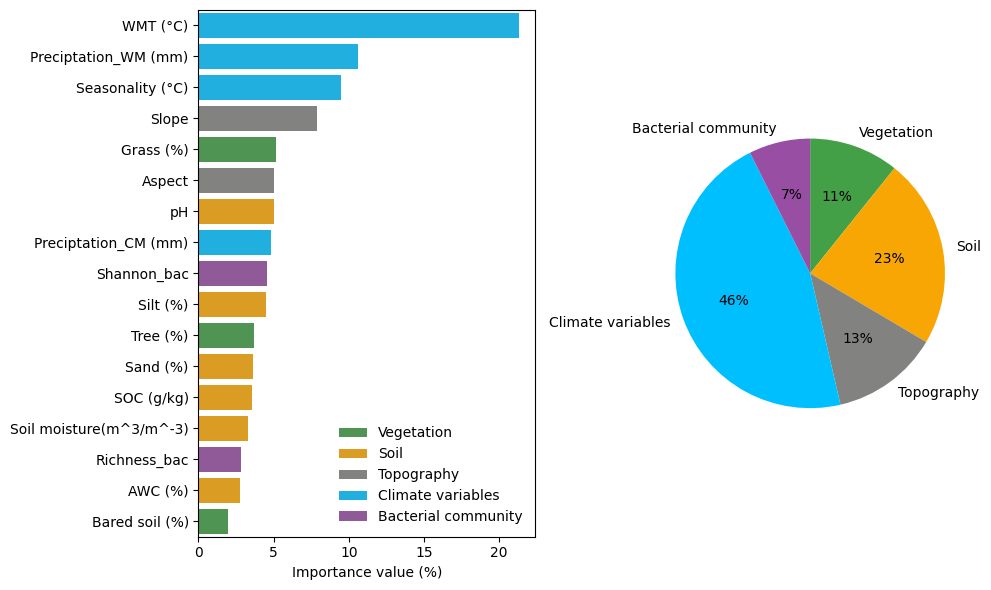

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

global_importances = pd.Series(
    gbr_best_model.feature_importances_,
    index=X_train.columns
)
global_importances.sort_values(ascending=False, inplace=True)

Im_df = global_importances.to_frame().reset_index()
Im_df.columns = ['feature', 'importance_value']

def feature_stat(value):
    if value in ["Bared soil (%)", "Tree (%)", "Grass (%)"]:
        return "Vegetation"

    if value in [
        "AWC (%)", "SOC (g/kg)", "Silt (%)", "Sand (%)", "pH",
        "Soil moisture(m^3/m^-3)"
    ]:
        return "Soil"

    if value in ["Slope", "Aspect"]:
        return "Topography"

    if value in [
        "Preciptation_CM (mm)", "Preciptation_WM (mm)",
        "Seasonality (°C)", "WMT (°C)", "CMT (°C)"
    ]:
        return "Climate variables"

    if value in ["Shannon_bac", "Richness_bac"]:
        return "Bacterial community"

Im_df['Category'] = Im_df['feature'].apply(feature_stat)

sum_value = Im_df['importance_value'].sum()
Im_df['importance_value (%)'] = Im_df['importance_value'].div(sum_value) * 100

category_palette = {
    "Vegetation": "#43A047",
    "Soil": "#f8a604",
    "Topography": "#828280",
    "Climate variables": "#00bffe",
    "Bacterial community": "#984ea3"
}

Im_df['Category'] = pd.Categorical(
    Im_df['Category'],
    categories=[
        "Vegetation",
        "Soil",
        "Topography",
        "Climate variables",
        "Bacterial community"
    ],
    ordered=False
)

sns.reset_defaults()
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)

sns.barplot(
    x='importance_value (%)',
    y='feature',
    data=Im_df,
    hue='Category',
    dodge=False,
    palette=category_palette
)

plt.xlabel('Importance value (%)')
plt.ylabel('')
plt.legend(title='', frameon=False, loc='lower right')

plt.subplot(1, 2, 2)

Im = (
    Im_df
    .groupby('Category')['importance_value (%)']
    .sum()
    .reset_index()
)

Im = Im[Im['importance_value (%)'] > 0]

pie_colors = Im['Category'].map(category_palette).values

pie_wedge_collection = plt.pie(
    Im['importance_value (%)'],
    labels=Im['Category'],
    explode=[0] * len(Im),
    colors=pie_colors,
    autopct='%1.0f%%',
    startangle=90,
    counterclock=False
)

for wedge in pie_wedge_collection[0]:
    wedge.set_edgecolor('none')

plt.ylabel('')
plt.tight_layout()
plt.show()


In [34]:
# Extract the names of the top 6 features
top_6_features = Im_df['feature'].head(6).tolist()
# Extract the names of all features except the top 6
remaining_features = Im_df['feature'].iloc[6:].tolist()
# Print the top 6 feature names
print("Top 6 features:", top_6_features)
# Print the remaining feature names
print("Remaining features (excluding top 6):", remaining_features)

Top 6 features: ['WMT (°C)', 'Preciptation_WM (mm)', 'Seasonality (°C)', 'Slope', 'Grass (%)', 'Aspect']
Remaining features (excluding top 6): ['pH', 'Preciptation_CM (mm)', 'Shannon_bac', 'Silt (%)', 'Tree (%)', 'Sand (%)', 'SOC (g/kg)', 'Soil moisture(m^3/m^-3)', 'Richness_bac', 'AWC (%)', 'Bared soil (%)']


In [36]:
Im_df.rename(columns={'feature': 'Variable'}, inplace=True)
styled_table = Im_df[['Variable', 'Category', 'importance_value (%)']].sort_values(by='importance_value (%)', ascending=False).style.format({
    "importance_value (%)": "{:.2f}"  # Format 'importance_value (%)' to 2 decimal places
})
styled_table

In [37]:
# Category Percentage 
# Calculate the total percentage of importance for each Category
category_percentages = Im_df.groupby('Category')['importance_value (%)'].sum().reset_index()

# Round the calculated percentages to two decimal places for better readability
category_percentages['importance_value (%)'] = category_percentages['importance_value (%)'].round(2)

# Display the resulting DataFrame showing the total percentage of importance for each Category
category_percentages

Category  importance_value (%)
0           Vegetation                 10.76
1                 Soil                 22.75
2           Topography                 12.89
3    Climate variables                 46.24
4  Bacterial community                  7.36

## Step 6 Partial Dependence Analysis Using GBR

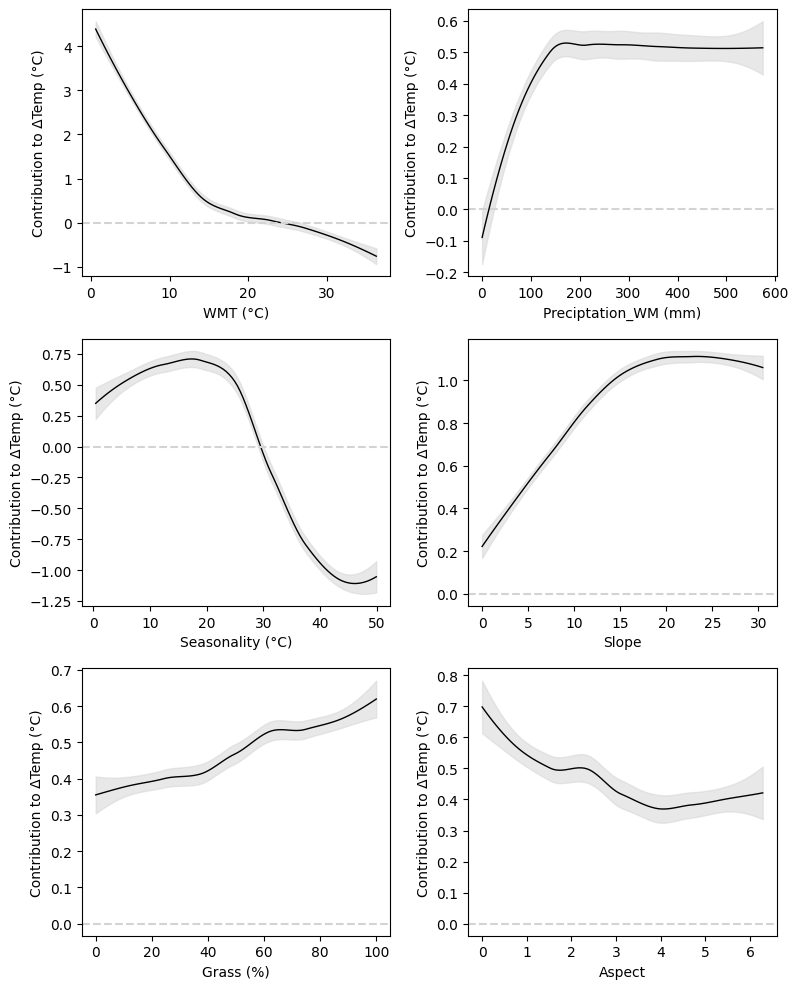

In [38]:
np.random.seed(1)  # for consistancy
# select relavent data
X_imputed = df_variable.drop(columns=["deltaMAF-BNN"])
y_imputed = df_variable[["deltaMAF-BNN"]].values 

gbr_best_model = GradientBoostingRegressor(
    n_estimators=615,
    max_depth=6,
    min_samples_split=8,
    min_samples_leaf=18,
    max_features='sqrt',
    learning_rate=0.019653314740731023,
    subsample= 0.8,
    criterion='friedman_mse',
    random_state=42
).fit(X_imputed, y_imputed)


def compute_pdp_loess(feature_name, X, model, frac=0.1):
    feature_values = np.linspace(np.min(X[feature_name]), np.max(X[feature_name]), 100)
    
    pdp_values = []
    for n in feature_values:
        X_pdp = X.copy()
        X_pdp[feature_name] = n
        
        # Compute the PDP
        pdp_value = np.mean(model.predict(X_pdp))
        pdp_values.append(pdp_value)
    
    # Apply LOESS smoothing
    l = loess(feature_values, pdp_values, frac=frac)
    l.fit()
    
    # Predict LOESS values and compute confidence intervals
    pred = l.predict(feature_values, stderror=True)
    conf = pred.confidence(alpha=0.05)
    
    smoothed_values = pred.values
    lower_conf = conf.lower
    upper_conf = conf.upper
    
    return smoothed_values, lower_conf, upper_conf, feature_values


selected_features = top_6_features

fig, axs = plt.subplots(3, 2, figsize=(8,10))
axs = axs.ravel()


for i, feature_name in enumerate(selected_features):
    #print(f"Processing feature: {feature_name}")
    smoothed_values, lower_conf, upper_conf, feature_values = compute_pdp_loess(
        feature_name, pd.DataFrame(X_imputed, columns=X.columns), 
        gbr_best_model, frac=0.1)
    
    # Plotting
    axs[i].plot(feature_values, smoothed_values, color='black', label='LOESS Smoothed Line', linewidth=1)
    axs[i].fill_between(feature_values, lower_conf, upper_conf, alpha=.5, color='#D3D3D3')
    axs[i].axhline(y=0, color='#D3D3D3', linestyle='--')
    axs[i].set_xlabel(feature_name)
    axs[i].set_ylabel('Contribution to ΔTemp (°C)')

# Adjust the layout of subplots
plt.tight_layout()
plt.show()

In [39]:
import numpy as np
import statsmodels.api as sm
from scipy.stats import f
np.random.seed(1)  # for consistancy
# select relavent data
X_imputed = df_variable.drop(columns=["deltaMAF-BNN"])
y_imputed = df_variable[["deltaMAF-BNN"]].values 
# Chow Test implementation
def chow_test(X, y, breakpoint):
    # Split data
    X1, X2 = X[X < breakpoint], X[X >= breakpoint]
    y1, y2 = y[:len(X1)], y[len(X1):]
    
    # Fit regression models
    model1 = sm.OLS(y1, sm.add_constant(X1)).fit()
    RSS1 = np.sum(model1.resid**2)
    
    model2 = sm.OLS(y2, sm.add_constant(X2)).fit()
    RSS2 = np.sum(model2.resid**2)
    
    model_full = sm.OLS(y, sm.add_constant(X)).fit()
    RSS_full = np.sum(model_full.resid**2)
    
    n1, n2 = len(X1), len(X2)
    k = 2  # Number of parameters (intercept and slope)
    
    # Chow Test statistic
    F_stat = ((RSS_full - (RSS1 + RSS2)) / k) / ((RSS1 + RSS2) / (n1 + n2 - 2 * k))
    p_value = 1 - f.cdf(F_stat, k, n1 + n2 - 2 * k)
    
    return F_stat, p_value
# Define the function to compute PDP and apply LOESS smoothing
def compute_pdp_loess(feature_name, X, model, frac=0.1):
    feature_values = np.linspace(np.min(X[feature_name]), np.max(X[feature_name]), 100)
    
    pdp_values = []
    for n in feature_values:
        X_pdp = X.copy()
        X_pdp[feature_name] = n
        
        # Compute the PDP
        pdp_value = np.mean(model.predict(X_pdp))
        pdp_values.append(pdp_value)
    
    # Apply LOESS smoothing
    l = loess(feature_values, pdp_values, frac=frac)
    l.fit()
    
    # Predict LOESS values and compute confidence intervals
    pred = l.predict(feature_values, stderror=True)
    conf = pred.confidence(alpha=0.05)
    
    smoothed_values = pred.values
    lower_conf = conf.lower
    upper_conf = conf.upper
    
    return smoothed_values, lower_conf, upper_conf, feature_values

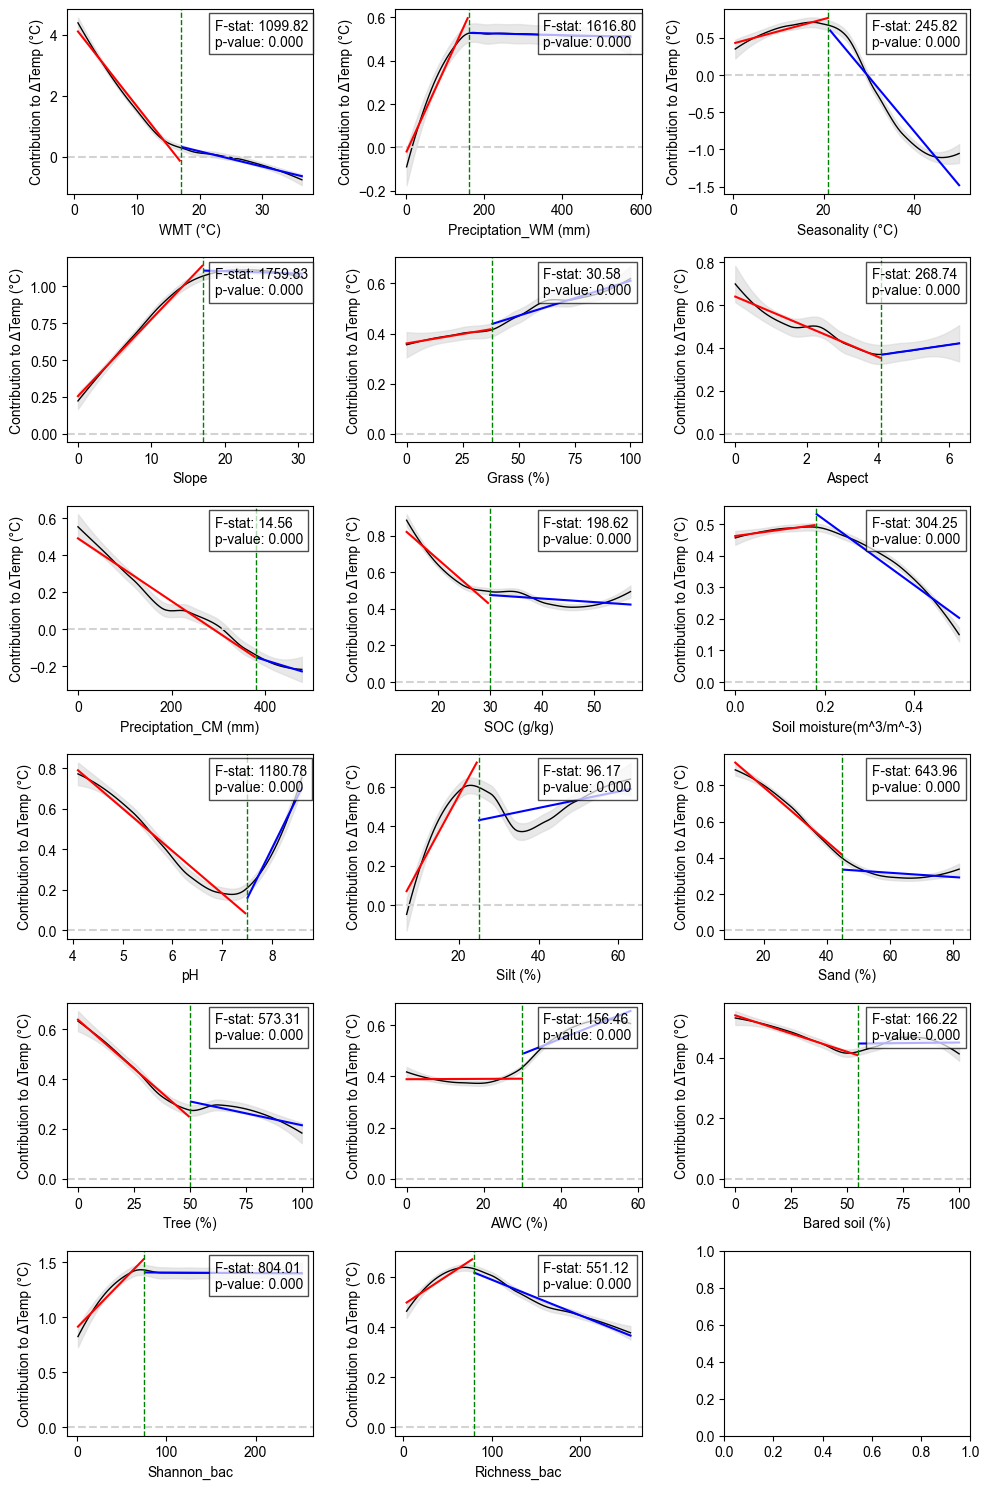

In [40]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'  
all_features = [
    'WMT (°C)',
    'Preciptation_WM (mm)',
    'Seasonality (°C)',
    'Slope',
    'Grass (%)',
     'Aspect',
    'Preciptation_CM (mm)', 
    'SOC (g/kg)',
    'Soil moisture(m^3/m^-3)',
    'pH',
    'Silt (%)',
    'Sand (%)',
    'Tree (%)',
    'AWC (%)',
    'Bared soil (%)',
    'Shannon_bac',
    'Richness_bac'
]
# Select the features and breakpoints
selected_features_secondary = all_features
breakpoints_secondary = [17, 160, 21, 17, 38,4.1, 380, 30, 0.18 ,7.5, 25, 45, 50, 30, 55,75,80]  # Breakpoints for each feature

fig, axs = plt.subplots(6, 3, figsize=(10, 15))
axs = axs.ravel()

# Process each feature and compute the LOESS smoothed PDP
for i, feature_name in enumerate(selected_features_secondary):
    breakpoint = breakpoints_secondary[i]
    try:
        # Compute LOESS and segmented regression
        smoothed_values, lower_conf, upper_conf, feature_values = compute_pdp_loess(
            feature_name, pd.DataFrame(X_imputed, columns=X.columns), 
            gbr_best_model, frac=0.1
        )

        # Plot LOESS smoothed PDP
        axs[i].plot(feature_values, smoothed_values, color='black', label='LOESS Smoothed Line', linewidth=1)
        axs[i].fill_between(feature_values, lower_conf, upper_conf, alpha=.5, color='#D3D3D3')
        axs[i].axhline(y=0, color='#D3D3D3', linestyle='--')

        # Perform segmented regression
        t1, y1 = feature_values[feature_values < breakpoint], smoothed_values[feature_values < breakpoint]
        t2, y2 = feature_values[feature_values >= breakpoint], smoothed_values[feature_values >= breakpoint]
        
        if len(t1) > 1 and len(t2) > 1:  # Ensure sufficient data points for regression
            # First segment regression
            model1 = sm.OLS(y1, sm.add_constant(t1)).fit()
            axs[i].plot(t1, model1.predict(sm.add_constant(t1)), color="red", linewidth=1.5, label="Segment 1 Regression")
            
            # Second segment regression
            model2 = sm.OLS(y2, sm.add_constant(t2)).fit()
            axs[i].plot(t2, model2.predict(sm.add_constant(t2)), color="blue", linewidth=1.5, label="Segment 2 Regression")
            
            # Plot the breakpoint
            axs[i].axvline(x=breakpoint, color="green", linestyle="--", linewidth=1, label="Breakpoint")

            # Perform Chow Test
            y_combined = np.concatenate([model1.fittedvalues, model2.fittedvalues])
            F_stat, p_value = chow_test(feature_values, smoothed_values, breakpoint)

            # Display Chow Test results dynamically adjusted to an empty corner
            # axs[i].text(
            #     0.6, 0.8,  # Adjusted position (top-right corner of the subplot)
            #     f"Chow Test\nF-stat: {F_stat:.2f}\np-value: {p_value:.3f}",
            #     transform=axs[i].transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.7)
            # )
            axs[i].text(
                0.6, 0.8,  # Adjusted position (top-right corner of the subplot)
                f"F-stat: {F_stat:.2f}\np-value: {p_value:.3f}",
                transform=axs[i].transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.7)
            )

                
        else:
            axs[i].text(
                0.5, 0.5, "Insufficient Data for Segmentation", 
                transform=axs[i].transAxes, fontsize=10, color="red", ha="center", va="center"
            )

        # Add axis labels
        axs[i].set_xlabel(feature_name)
        axs[i].set_ylabel('Contribution to ΔTemp (°C)')
    except ValueError as e:
        axs[i].text(
            0.5, 0.5, "Data Error", 
            
            transform=axs[i].transAxes, fontsize=12, ha="center", va="center", color="red"
        )
        continue

# Adjust the layout of subplots
plt.tight_layout()
plt.show()


# Fig 3. Bacterial data anlysis

C:\Users\jie liang\AppData\Local\Temp\ipykernel_22604\1552264094.py:10: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, encoding='ISO-8859-1')


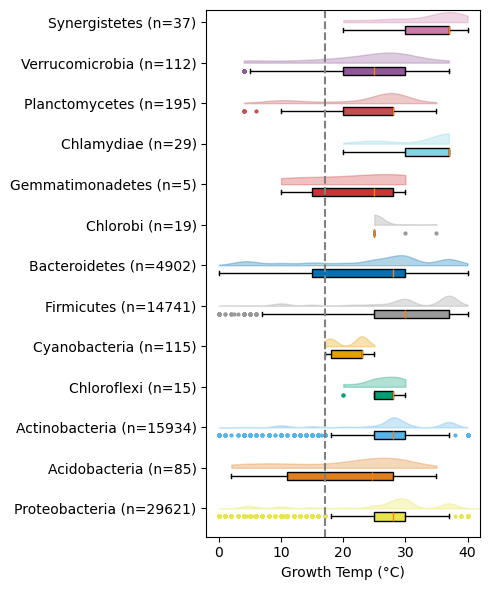

 Total records (non-NaN MIN & phylum): 65810


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# ——— 全局配置 ———

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype']  = 42

file_path = r"D:\bacterial_data.csv"
df = pd.read_csv(file_path, encoding='ISO-8859-1')

columns_to_fill = ['ID', 'designation_header', 'strain_number_header', 'is_type_strain_header', 'species', 'phylum']
df[columns_to_fill] = df[columns_to_fill].ffill()


df = df.dropna(subset=['phylum', 'MIN'])


df['phylum'] = df['phylum'].astype(str)


phylum_counts = df['phylum'].value_counts()
df['phylum_with_counts'] = df['phylum'].apply(lambda x: f"{x} (n={phylum_counts[x]})")


custom_order = [
    "Proteobacteria", "Acidobacteria", "Actinobacteria", "Chloroflexi",
    "Cyanobacteria", "Firmicutes", "Bacteroidetes", "Chlorobi",
    "Gemmatimonadetes", "Chlamydiae", "Planctomycetes", "Verrucomicrobia", 
    "Synergistetes"
]

custom_order_with_counts = [f"{phylum} (n={phylum_counts.get(phylum, 0)})" for phylum in custom_order]


harmonized_colors = ["#e6e64c", "#df7f20", "#56B4E9", "#009E73", "#E69F00", "#999999", 
                     "#0072B2", "#999999",  "#cb3335", "#85D4E3", "#C44E52", #"#E66100","#964A00", 
                     "#905998", "#CC79A7"]


df['phylum_with_counts'] = pd.Categorical(df['phylum_with_counts'], categories=custom_order_with_counts, ordered=True)


grouped_data = [df[df['phylum_with_counts'] == phylum]['MIN'] for phylum in custom_order_with_counts]


fig, ax = plt.subplots(figsize=(5,6))


for i, (data, color) in enumerate(zip(grouped_data, harmonized_colors), start=1):
    
    flierprops = dict(marker='o', markerfacecolor=color, markersize=2, linestyle='none', markeredgecolor=color)
    
    
    ax.boxplot(data, patch_artist=True, vert=False, widths=0.2, positions=[i - 0.2], 
               boxprops=dict(facecolor=color), flierprops=flierprops)# , alpha=0.8

# 绘制小提琴图
vp = ax.violinplot(grouped_data, points=500, showmeans=False, showextrema=False, showmedians=False, vert=False)


for idx, b in enumerate(vp['bodies']):
    b.get_paths()[0].vertices[:, 1] = np.clip(b.get_paths()[0].vertices[:, 1], idx + 1, idx + 2)
    b.set_color(harmonized_colors[idx]) 


plt.yticks(np.arange(1, len(custom_order_with_counts) + 1), custom_order_with_counts)
plt.xlabel('Growth Temp (°C)')
plt.axvline(x=17, color='grey', linestyle='--')  
plt.xlim(-2,42)

plt.tight_layout()
plt.savefig("Fig.3 bacterial.pdf", bbox_inches='tight')
plt.show()

total_count = len(df)
print(f" Total records (non-NaN MIN & phylum): {total_count}")


# Fig.4 SINDY constraint

In [4]:
import numpy as np
import time
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error   
import matplotlib.pyplot as plt
from sympy import sympify, symbols, evaluate
from scipy.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


print(np.__version__)

1.26.4


## Step 1: SINDY anlysis

In [42]:

def TrainSTRidge(R, Ut, lam, d_tol, maxit=10, STR_iters=10,
                 l0_penalty=None, normalize=2, split=0.8, print_best_tol=True):
    """
    This function trains a predictor using STRidge.

    It runs over different values of tolerance and trains predictors on a training set, then evaluates them
    using a loss function on a holdout set.

    Please note published article has typo.  Loss function used here for model selection evaluates fidelity using 2-norm,
    not squared 2-norm.
    """

    # Split data into 80% training and 20% test, then WMT_soilrch for the best tolderance.
    np.random.seed(1)  # for consistancy
    n, _ = R.shape
    train = np.random.choice(n, int(n * split), replace=False)
    test = [i for i in np.arange(n) if i not in train]
    TrainR = R[train, :]
    TestR = R[test, :]
    TrainY = Ut[train, :]
    TestY = Ut[test, :]
    D = TrainR.shape[1]

    # Set up the initial tolerance and l0 penalty
    d_tol = float(d_tol)
    tol = d_tol
    # print(tol)
    if l0_penalty == None: l0_penalty = 0.001 * np.linalg.cond(R)

    # Get the standard least squares estimator
    w = np.zeros((D, 1))
    w_best = np.linalg.lstsq(TrainR, TrainY, rcond=None)[0]
    err_best = np.linalg.norm(TestY - TestR.dot(w_best), 2) + l0_penalty * np.count_nonzero(w_best)
    tol_best = 0
    err_ = []
    # Now increase tolerance until test performance decreases
    for iter in range(maxit):
        # Get a set of coefficients and error
        w = STRidge(TrainR, TrainY, lam, STR_iters, tol, normalize=normalize)
     #   print('stridge', w)
        err1 = np.linalg.norm(TestR.dot(w), 2)
        err_.append(err1)
        err = np.linalg.norm(TestY - TestR.dot(w), 2) + l0_penalty * np.count_nonzero(w)
        # Has the accuracy improved?
        if err <= err_best:
            err_best = err
            w_best = w
            tol_best = tol
            tol = tol + d_tol
       #     print('比较err：',tol)

        else:
            tol = max([0, tol - 2 * d_tol])
            d_tol = 2 * d_tol / (maxit - iter)
            tol = tol + d_tol
         #   print('tol_max:', d_tol, tol)
            w_best = w

    if print_best_tol: print("Optimal tolerance:", tol_best)

    return w_best, TrainR, TestR, TrainY, TestY, err_, tol_best


def STRidge(X0, y, lam, maxit, tol, normalize, print_results=True):
    """
    Sequential Threshold Ridge Regression algorithm for finding (hopefully) sparse
    approximation to X^{-1}y.  The idea is that this may do better with correlated observables.

    This assumes y is only one column
    """
    n, d = X0.shape
    X = np.zeros((n, d), dtype=np.float32)
    # First normalize data
    if normalize != 0:
        Mreg = np.zeros((d, 1))
        for i in range(0, d):
            Mreg[i] = 1.0 / (np.linalg.norm(X0[:, i], normalize))
            X[:, i] = Mreg[i] * X0[:, i]
    else:
        X = X0

    # Get the standard ridge esitmate
    if lam != 0:
        w = np.linalg.lstsq(X.T.dot(X) + lam * np.eye(d), X.T.dot(y), rcond=None)[0]
    else:
        w = np.linalg.lstsq(X, y, rcond=None)[0]
    num_relevant = d
    biginds = np.where(abs(w) > tol)[0]

    for j in range(maxit):

        # Figure out which items to cut out
        smallinds = np.where(abs(w) < tol)[0]
   #     print('smallinds:', smallinds)
        new_biginds = [i for i in range(d) if i not in smallinds]

        # If nothing changes then stop
        if num_relevant == len(new_biginds):
            break
        else:
            num_relevant = len(new_biginds)

        # Also make sure we didn't just lose all the coefficients
        if len(new_biginds) == 0:
            if j == 0:
                if print_results: print("Tolerance too high - all coefficients set below tolerance")
                return w
            else:
                break
        biginds = new_biginds

        # Otherwise get a new guess
        w[smallinds] = 0
        if lam != 0:
            w[biginds] = \
                np.linalg.lstsq(X[:, biginds].T.dot(X[:, biginds]) + lam * np.eye(len(biginds)), X[:, biginds].T.dot(y),
                                rcond=None)[0]
        #    print('cutsmallinds', w)
        else:
            w[biginds] = np.linalg.lstsq(X[:, biginds], y, rcond=None)[0]


    if biginds != []: w[biginds] = np.linalg.lstsq(X[:, biginds], y, rcond=None)[0]

    if normalize != 0:
        return np.multiply(Mreg, w)
    else:
        return w


def evaluation(Y_true, Y_predict):
    MSE = mean_squared_error(Y_true, Y_predict)
    MAE = mean_absolute_error(Y_true, Y_predict)
    RMSE = MSE ** 0.5
    MAPE = np.mean(np.abs((Y_predict - Y_true) / Y_true)) * 100

    y_true = Y_true.flatten() if len(Y_true.shape) > 1 else Y_true.squeeze()
    y_predict = Y_predict.flatten() if len(Y_predict.shape) > 1 else Y_predict.squeeze()
    R, p_value = pearsonr(y_true, y_predict)
    return MSE, MAE, RMSE, MAPE, R



def SINDy(func_library, Y_ln, lam, dtol, maxit, func_name, x_max, y_max, savename, save_result):

     w_best, trainR, valR, trainY, valY, err_, tol_best = TrainSTRidge(func_library, Y_ln, lam, dtol, maxit, STR_iters=10,
                                                        l0_penalty=None,
                                                        normalize=2, split=0.8, print_best_tol=True)


     w_final_np = np.array([float(w_best[x][0])/x_max[x]*y_max[0] for x in range(len(w_best))])

     if save_result is True:
         np.savetxt('result/w_final_'+ str(savename) + '_' + str(lam) + '_' + str(dtol) + '.txt',
                    w_final_np, fmt='%.4f')
         equ = equation(w_final_np, func_name)
         with open('result/equation_'+str(savename) + '.txt', 'w',
                   encoding='utf-8') as f:
             f.write(equ)
             f.close()
     return w_final_np, equ


def equation(w, func_name):
    co = []
    fuc = []
    disc_eq_temp = []
    for i in range(w.shape[0]):
        if w[i] != 0:
            co.append(format(w[i], '.4f'))
            fuc.append(func_name[i])
            disc_eq_temp.append(str(format(w[i], '.3f')) + '*' + func_name[i])

    disc_eq = '+'.join(disc_eq_temp)
    equ = 'deltaMAF = ' + disc_eq
    print(equ)
    return equ


def prediction(equation, Precipwm_input, Constant_input,WMT_input):
    s = sympify(equation)
    Precipwm, WMT,constant,lnPrecipwm, lnWMT,expPrecipwm,expWMT = symbols('Precipwm WMT constant lnPrecipwm lnWMT expPrecipwm expWMT')
    expr = s.subs([(Precipwm, Precipwm_input),(WMT, WMT_input),(expPrecipwm,np.log(Precipwm_input)),(constant,Constant_input),(expWMT,np.log(WMT_input)),
                   (lnPrecipwm, np.log(Precipwm_input)), (lnWMT, np.log(WMT_input))])
    expr_str = str(expr)
    result = float(eval(expr_str))
    return result


## Step 2: Constraint for temp bias

In [7]:

# Load the Excel file and select the relevant sheet
xls = pd.ExcelFile('gloabl soil brGDGT dataset - v2.xlsx')
df_check = pd.read_excel(xls, ' Temperature_Comparison')

# Select specific columns for analysis and remove rows with missing values
data = df_check[['hottest_month_pre', 'MWT(°C)', 'deltaMAF-WC bnn']].dropna()

# Display the number of rows after removing NA values
print("Number of rows after deleting NA values:", len(data))

# Extract input (X) and output (y) columns
input_data = data[['hottest_month_pre', 'MWT(°C)']]
output_data = data[['deltaMAF-WC bnn']]

# Remove outliers using the Z-score method
z_scores_soil = np.abs(stats.zscore(data[['MWT(°C)', 'deltaMAF-WC bnn']]))
filtered_entries_soil = (z_scores_soil < 3).all(axis=1)

z_scores_precip = np.abs(stats.zscore(data[['hottest_month_pre', 'deltaMAF-WC bnn']]))
filtered_entries_precip = (z_scores_precip < 3).all(axis=1)

# Combine the conditions to filter out outliers
filtered_data = data[filtered_entries_soil | filtered_entries_precip]
print("Number of rows after filtering outliers:", len(filtered_data))

# Update input and output variables with filtered data
input_filtered = filtered_data[['MWT(°C)', 'hottest_month_pre']]
output_filtered = filtered_data[['deltaMAF-WC bnn']]

# Display the column names of the filtered data
print("Columns in the filtered data:", filtered_data.columns)

# Start timing the process
time_start = time.time()

# Reassign filtered data as the main dataset for further processing
data = filtered_data

# Display the number of rows after filtering
print("Number of rows after filtering outliers:", len(data))

# Assign new input and output variables
input_data = data[['hottest_month_pre', 'MWT(°C)']]
output_data = data[['deltaMAF-WC bnn']]

# Rename input columns to shorter names for constructing the function library
input_data.columns = ['Precipwm', 'WMT']

# Define a list of operations to create a function library
# 'Precipwm WMT_soil constant logPrecipwm logWMT_soil expPrecipwm expWMT_soil')
func_dict = [
    'Precipwm', 'WMT', 'Precipwm*WMT', 'Precipwm**2', 'WMT**2', 
    'Precipwm**3', 'WMT**3', 'lnPrecipwm', 'expWMT', 'lnWMT', 'expPrecipwm'
]

# Construct the function library by applying operations to the input variables
func_library = pd.DataFrame(index=input_data.index)
for op in func_dict:
    if '**' in op:
        col_name, operation = op.split('**')
        func_library[op] = input_data[col_name] ** int(operation)
    elif '*' in op:
        col1, col2 = op.split('*')
        func_library[op] = input_data[col1] * input_data[col2]
    elif 'ln' in op:
        col_name = op[2:]
        func_library[op] = np.log(input_data[col_name])
    elif 'exp' in op:
        col_name = op[3:]
        func_library[op] = np.exp(input_data[col_name])
    elif op == 'constant':
        func_library[op] = 1

# Combine the original inputs with the function library
func_lib_all = pd.concat([input_data, func_library], axis=1)
func_lib_all = np.array(func_lib_all, dtype=np.float64)
output_data = np.array(output_data, dtype=np.float64)

# Normalize the function library and output data
x_max = np.max(func_lib_all, axis=0)
funclib_norm = func_lib_all / x_max
y_max = np.max(output_data, axis=0)
y_norm = output_data / y_max

# Parameter settings for the SINDy algorithm
lam = 0.1  # Regularization parameter
tol = 0.8  # Tolerance for small coefficients
iters = 2  # Number of iterations
savename = 3
save_result = True

# Solve the sparse regression problem using the SINDy algorithm
w_final, equ = SINDy(funclib_norm, y_norm, lam, tol, iters, func_dict, x_max, y_max, savename, save_result=save_result)
w_final_round3 = np.round(w_final, 3)
num_nonzero = np.count_nonzero(w_final_round3)
print('Number of non-zero terms:', num_nonzero)

# Predict the output using the derived equation
maf_pre = []
for i in range(len(input_data)):
    _ = prediction(equ[11:], input_data['Precipwm'].iloc[i], 0.5, input_data['WMT_soil'].iloc[i])
    maf_pre.append(_)



Number of rows after deleting NA values: 1998
Number of rows after filtering outliers: 1973
Columns in the filtered data: Index(['hottest_month_pre', 'MWT_Soil(°C)', 'deltaMAF-WC bnn'], dtype='object')
Number of rows after filtering outliers: 1973
Optimal tolerance: 1.6
deltaMAF = -0.285*WMT_soil+0.005*WMT_soil**2+0.875*lnPrecipwm
Number of non-zero terms: 3


# Fig. 4  land–atmosphere energy flux dynamics

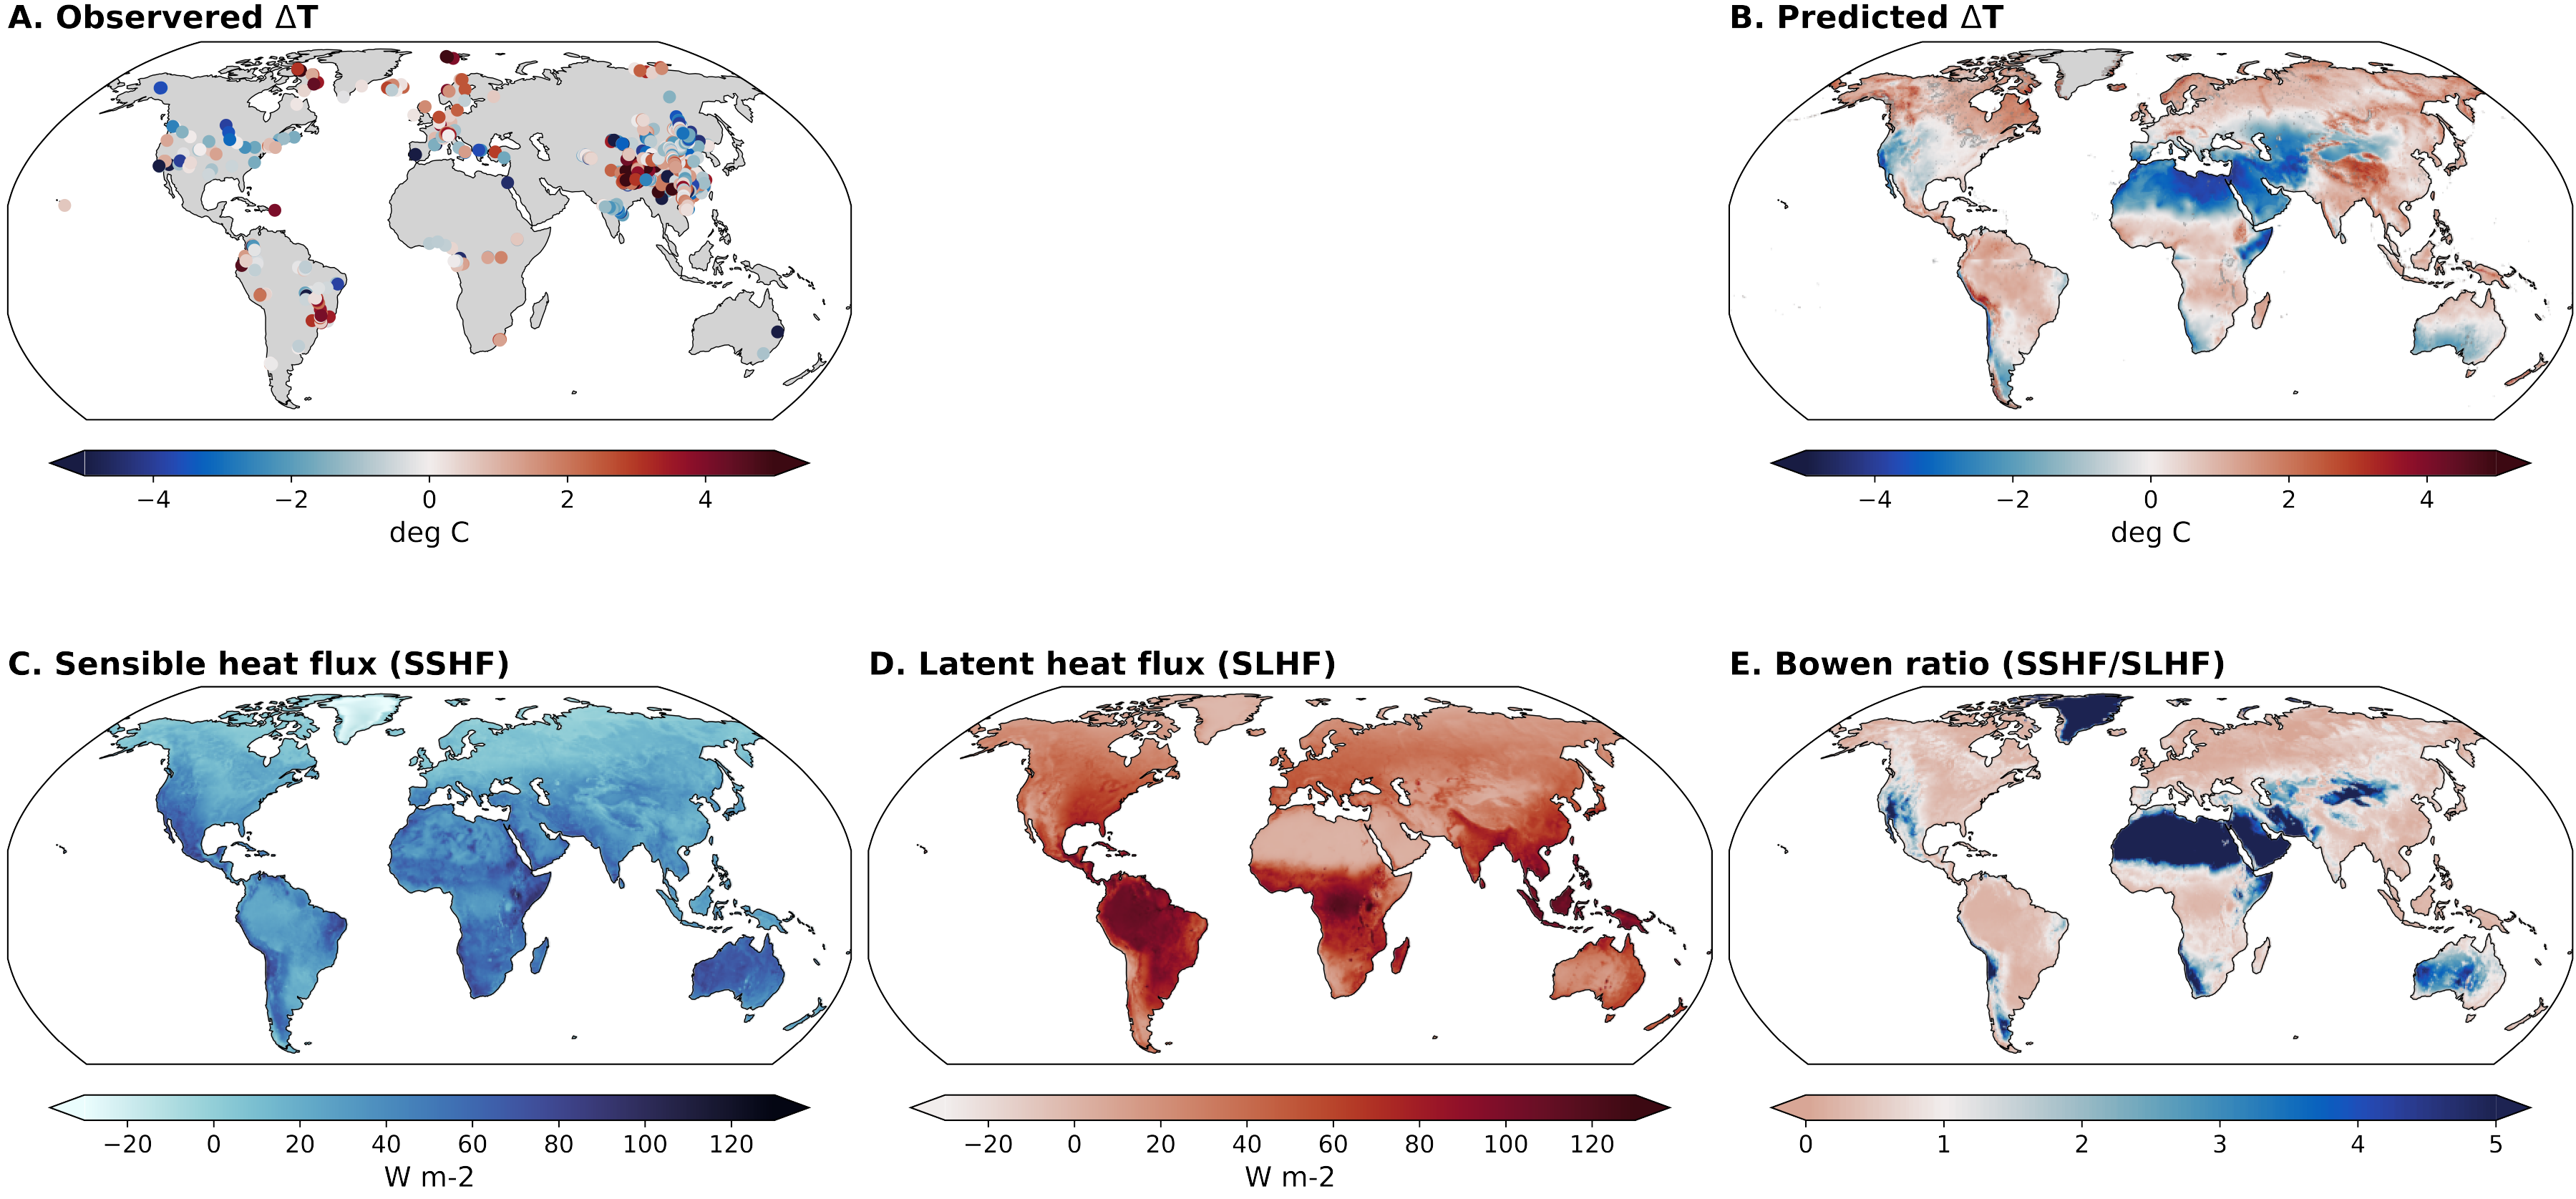

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
import cmocean
import regionmask
import pandas as pd

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42


def truncate_colormap(cmap, minval=0.1, maxval=0.9, n=256):
    return LinearSegmentedColormap.from_list(
        f"trunc({cmap.name},{minval:.2f},{maxval:.2f})",
        cmap(np.linspace(minval, maxval, n))
    )


folder = os.path.dirname(os.path.abspath(__file__))
file_names = [
    "B_1981_2018_ann.tif",
    "sshf_1981_2018_ann_Wm-2.tif",
    "slhf_1981_2018_ann_Wm-2.tif",
     "soil_ann.tif",
	"wc2.1_30s_tavg_ann.tif",
    "soilT-worldclim_ann.tif",
    "delta_temp.tif"
]

titles = [
    "E. Bowen ratio (SSHF/SLHF)",
    "C. Sensible heat flux (SSHF)",
    "D. Latent heat flux (SLHF)",   
    "F. Soil temperature",
    "G. Air temperature",
    "H. Soil-air temperature difference",
    "B. Predicted $\Delta$T$_{brGDGT-air}$"
]


units = ["", "W m-2", "W m-2", "deg C", "deg C", "deg C", "deg C"]
color_limits = [(0,5),(-30,130),(-30,130),(-30,30),(-30,30),(-10,10),(-5,5)]

cmaps = [
    truncate_colormap(cmocean.cm.balance_r,0.38,0.98),
    cmocean.cm.ice_r,
    cmocean.cm.amp,
    cmocean.cm.balance,
    cmocean.cm.balance,
    cmocean.cm.balance,
    cmocean.cm.balance
]

csv_path = 'brGDGT-MAF.csv'
df = pd.read_csv(csv_path)
df['deltaMAF'] = pd.to_numeric(df['deltaMAF'], errors='coerce')
df = df.dropna(subset=['Longitude_degE', 'Latitude_degN', 'deltaMAF'])

fig, axes = plt.subplots(3,3,figsize=(18,13.5),subplot_kw={'projection': ccrs.Robinson()},constrained_layout=True)
plot_data = [None,None,6,1,2,0,3,4,5]

for idx, data_idx in enumerate(plot_data):
    ax = axes.flatten()[idx]
    if idx == 1:
        ax.axis('off')
        continue
    if data_idx is not None:
        filename = file_names[data_idx]
        path = os.path.join(folder, filename)

        ax.set_title(titles[data_idx], fontsize=16, fontweight='bold', loc='left')
        ax.set_extent([-180, 180, -60, 90], crs=ccrs.PlateCarree())
        ax.coastlines(linewidth=0.5)
        ax.add_feature(cfeature.LAND, facecolor='lightgray')

        with rasterio.open(path) as src:
            data = src.read(1).astype('float32')
            data[data == src.nodata] = np.nan

            if "sshf" in filename or "slhf" in filename:
                data = -data

            transform = src.transform
            width, height = src.width, src.height
            lon = np.linspace(transform[2], transform[2] + transform[0]*(width-1), width)
            lat = np.linspace(transform[5], transform[5] + transform[4]*(height-1), height)
            lon[lon > 180] -= 360
            sort_idx = np.argsort(lon)
            data = data[:, sort_idx]
            lon = lon[sort_idx]
            lon2d, lat2d = np.meshgrid(lon, lat)

            if data_idx <= 2:
                mask = regionmask.defined_regions.natural_earth_v5_1_2.land_110.mask(lon2d, lat2d)
                data = np.where(np.isnan(mask), np.nan, data)

            data[lat2d<-60] = np.nan

            im = ax.imshow(data, extent=[lon.min(), lon.max(), lat.min(), lat.max()], transform=ccrs.PlateCarree(), cmap=cmaps[data_idx], vmin=color_limits[data_idx][0], vmax=color_limits[data_idx][1], origin='upper')

            cbar = fig.colorbar(im, ax=ax, orientation='horizontal', pad=0.05, aspect=30, shrink=0.9, extend='both')
            cbar.set_label(units[data_idx], fontsize=14)
            cbar.ax.tick_params(labelsize=12)
    else:
        ax.set_title("A. $\Delta$T$_{brGDGT-air}$", fontsize=16, fontweight='bold', loc='left')
	#ax.set_title(r"$\mathbf{A.\ T_{brGDGT-air}}$", fontsize=16, loc='left')
        ax.set_extent([-180,180,-60,90],crs=ccrs.PlateCarree())
        ax.coastlines(linewidth=0.5)
        ax.add_feature(cfeature.OCEAN, facecolor='white')
        ax.add_feature(cfeature.LAND, facecolor='lightgray')

        sc = ax.scatter(df['Longitude_degE'], df['Latitude_degN'], c=df['deltaMAF'], cmap=cmocean.cm.balance, vmin=-5, vmax=5, s=30, transform=ccrs.PlateCarree(), zorder=10)
        cbar2 = fig.colorbar(sc, ax=ax, orientation='horizontal', pad=0.05, aspect=30, shrink=0.9, extend='both')
        cbar2.set_label('deg C', fontsize=14)
        cbar2.ax.tick_params(labelsize=12)

output_pdf = os.path.join(folder, "Figure 4.energy plot.pdf")
plt.savefig(output_pdf, format='pdf', bbox_inches='tight')
print(f"Saved to: {output_pdf}")

plt.show() 



# Fig. 5

### Schematic diagram (Fig. 5A)

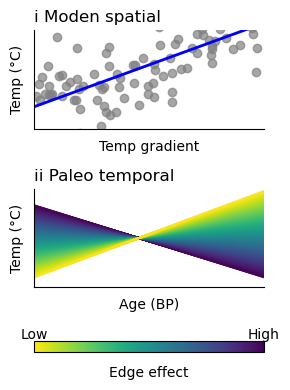

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from matplotlib import cm
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(3, 4), sharex=False, gridspec_kw={'height_ratios': [1,1.8]})

np.random.seed(42)
x = np.random.uniform(0, 30, 100)
y = 0.8 * x + 1 + np.random.normal(0, 5, 100)
y[(x >= 0) & (x <= 5)] += 3
y[(x >= 25) & (x <= 30)] -= 3

slope, intercept, r_value, _, std_err = linregress(x, y)

x_line = np.linspace(0, 30, 100)
y_line = slope * x_line + intercept
n = len(x)
se = std_err * np.sqrt(1/n + (x_line - np.mean(x))**2 / np.sum((x - np.mean(x))**2))
confidence_interval = 1.96 * se  

y_upper = y_line + confidence_interval
y_lower = y_line - confidence_interval

mask = ~((x >= 0) & (x <= 5) & (y < (slope * x + intercept)))
mask &= ~((x >= 25) & (x <= 30) & (y > (slope * x + intercept)))
x_filtered = x[mask]
y_filtered = y[mask]


#ax1.scatter(x_filtered, y_filtered, color='gray', alpha=0.7, edgecolor='gray')
ax1.scatter(x_filtered, y_filtered, color='gray', alpha=0.7)


ax1.plot(x_line, y_line, color='blue', linewidth=2)


ax1.fill_between(x_line, y_lower, y_upper, color='blue', alpha=0.2)


ax1.set_xlim(0, 30)
ax1.set_ylim(0, 20)
ax1.set_xlabel('Temp gradient')
ax1.set_ylabel('Temp (°C)')


ax1.set_xticklabels([])
ax1.set_yticklabels([])

ax1.set_title('i Moden spatial', loc='left')


ax1.grid(False)


ax1.spines['top'].set_color('none')
ax1.spines['right'].set_color('none')


ax1.spines['left'].set_position(('data', 0))
ax1.spines['bottom'].set_position(('data', 0))

ax1.tick_params(axis='both', which='both', length=0)


x = np.linspace(0, 22, 100)


slopes = np.linspace(-1, 1.2, 2000)


colors = cm.viridis(np.linspace(0, 1, len(slopes)))


offset = 10  


for i, m in enumerate(slopes):
    y = m * (x - offset) + 15  
    ax2.plot(x, y, color=colors[i], alpha=0.2)


ax2.set_xlim(0, 22)  # Set X axis from 0 to 22
ax2.set_ylim(0, 30)  # Set Y axis from 0 to 30
ax2.set_xlabel("Age (BP)")
ax2.set_ylabel("Temp (°C)")


ax2.set_xticklabels([])
ax2.set_yticklabels([])


ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

ax2.set_title('ii Paleo temporal', loc='left')


ax2.spines['left'].set_position('zero')
ax2.spines['bottom'].set_position('zero')
ax2.tick_params(axis='both', which='both', length=0)


sm = plt.cm.ScalarMappable(cmap=cm.viridis, norm=plt.Normalize(vmin=0.6, vmax=1))
sm.set_array([])  # Only needed for colorbar
cbar = fig.colorbar(sm, ax=ax2, orientation='horizontal', pad=0.3, aspect=20)
cbar.set_label("Edge effect", rotation=0, labelpad=10)
cbar.ax.set_xticks([])  
cbar.ax.invert_xaxis()  


cbar.ax.text(0, 1.5, "Low", ha='center', va='center', transform=cbar.ax.transAxes, fontsize=10)
cbar.ax.text(1, 1.5, "High", ha='center', va='center', transform=cbar.ax.transAxes, fontsize=10)


plt.tight_layout()

plt.show()


## Spatial scales (Fig. 5B)

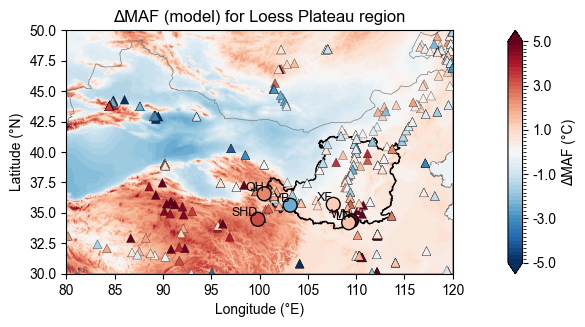

In [47]:
import rasterio
from rasterio.windows import from_bounds
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
from shapely.geometry import box
from sklearn.impute import KNNImputer

# File paths
precipitation_file = "C:/Users/jie liang/Liang et al.,2024 code/wc2.1_30s_prec_07.tif"
temperature_file = "C:/Users/jie liang/Liang et al.,2024 code/wc2.1_30s_tem_07.tif"
shapefile_path = "C:/Users/jie liang/Liang et al.,2024 code/LoessPlateauRegion/LoessPlateauRegion.shp"
file_path = "C:/Users/jie liang/gloabl soil brGDGT dataset - v2.xlsx"

# Load raster data
with rasterio.open(precipitation_file) as precip_src:
    precipitation = precip_src.read(1, masked=True)
    precip_transform = precip_src.transform

with rasterio.open(temperature_file) as temp_src:
    temperature = temp_src.read(1, masked=True) / 10.0  # Adjust temperature
    temp_transform = temp_src.transform

# Define the extent for cropping (longitude and latitude)
bounds = (80, 30, 120, 50)
window = from_bounds(bounds[0], bounds[1], bounds[2], bounds[3], transform=precip_transform)

# Read the cropped raster data
with rasterio.open(precipitation_file) as precip_src:
    cropped_precipitation = precip_src.read(1, window=window, masked=True)

with rasterio.open(temperature_file) as temp_src:
    cropped_temperature = temp_src.read(1, window=window, masked=True) / 10.0  # Adjust temperature

# Load Excel data and filter by extent
df = pd.read_excel(file_path, sheet_name=" Temperature_Comparison")
extent = {'min_lat': 30, 'max_lat': 50, 'min_lon': 80, 'max_lon': 120}
filtered_df = df[(df['Latitude_degN'] >= extent['min_lat']) & (df['Latitude_degN'] <= extent['max_lat']) &
                 (df['Longitude_degE'] >= extent['min_lon']) & (df['Longitude_degE'] <= extent['max_lon'])]

# Calculate deltaMAF
deltaMAF = (
    -0.285 * cropped_temperature
    + 0.005 * cropped_temperature* cropped_precipitation 
    + 0.875 * np.log(cropped_precipitation + 1)
)
# Fill missing values using KNN imputation
imputer = KNNImputer(n_neighbors=5, weights="uniform")
deltaMAF_filled = imputer.fit_transform(deltaMAF)

# Load shape files
china_boundary = gpd.read_file("C:/Users/jie liang/Liang et al.,2024 code/chinashp.shp")
loess_plateau_shape = gpd.read_file(shapefile_path)

# Get raster CRS and align shape files
with rasterio.open(precipitation_file) as src:
    raster_crs = src.crs

loess_plateau_shape = loess_plateau_shape.to_crs(raster_crs)
china_boundary = china_boundary.to_crs(raster_crs)

# Create a boundary box
deltaMAF_bounds = box(bounds[0], bounds[1], bounds[2], bounds[3])
clipped_china_boundary = gpd.clip(china_boundary, deltaMAF_bounds)

# Scatter plot data
points_data = {
    "name": ["SHD", "QH", "XF", "WN", "YB", "LT"],
    "lat": [34.47, 36.57, 35.7, 34.35, 35.63, 34.19],
    "lon": [99.83, 100.48, 107.63, 109.53, 103.17, 109.23],
    "deltaMAF": [3.3, 2.49, 1.25, 6.36, -2.36, 1.49]
}
points_df = gpd.GeoDataFrame(points_data, geometry=gpd.points_from_xy(points_data["lon"], points_data["lat"]), crs="EPSG:4326")
points_df = points_df.to_crs(raster_crs)

# Plot the deltaMAF map
fig, ax = plt.subplots(figsize=(6, 4))
cmap = plt.cm.RdBu_r  # Reverse color map
levels = np.linspace(-5, 5, 61)
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

cax = ax.imshow(deltaMAF_filled, cmap=cmap, extent=(bounds[0], bounds[2], bounds[1], bounds[3]), norm=norm)
ax.set_title("DeltaMAF plot")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Plot clipped China boundary and shape file
clipped_china_boundary.plot(ax=ax, edgecolor='grey', linewidth=0.5, facecolor='none')
loess_plateau_shape.plot(ax=ax, edgecolor='black', facecolor='none')

# Plot scatter points
colors = cmap(norm(points_df["deltaMAF"]))
scatter = ax.scatter(points_df.geometry.x, points_df.geometry.y, color=colors, edgecolor='black', s=100)
for x, y, label in zip(points_df.geometry.x, points_df.geometry.y, points_df["name"]):
    ax.text(x, y, label, fontsize=10, ha='right', color='black')

# Plot filtered data from Excel
filtered_gdf = gpd.GeoDataFrame(filtered_df, geometry=gpd.points_from_xy(filtered_df['Longitude_degE'], filtered_df['Latitude_degN']), crs="EPSG:4326")
filtered_gdf = filtered_gdf.to_crs(raster_crs)
filtered_colors = cmap(norm(filtered_gdf["deltaMAF-WC bnn"]))
ax.scatter(filtered_gdf.geometry.x, filtered_gdf.geometry.y, color=filtered_colors, edgecolor='black', s=50, marker='^', linewidths=0.1)

# Add color bar
divider = make_axes_locatable(ax)
cbar_ax = divider.append_axes("bottom", size="8%", pad=0.5)
cbar = fig.colorbar(cax, cax=cbar_ax, orientation='horizontal', ticks=np.arange(-5, 6, 1), extend='both')
cbar.set_label('DeltaMAF')

plt.tight_layout()
plt.show()



## temporal scales (Fig. 5C)

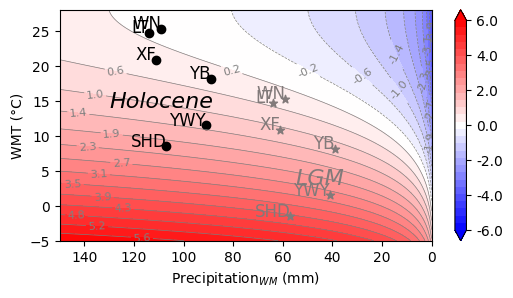

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from matplotlib.colors import LinearSegmentedColormap

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42 

cmap = LinearSegmentedColormap.from_list('custom_cmap', 
                                         [(0, 'blue'), 
                                          (0.5, 'white'), 
                                          (1, 'red')])
precipitation = np.linspace(0, 150, 200)
temperature = np.linspace(-5, 28, 200)

temperature_grid, precipitation_grid = np.meshgrid(temperature, precipitation)
points = np.array([[p, t] for t in temperature for p in precipitation])

def calculate_deltaMAF(precipitation, temperature):
    log_precipitation = np.log(precipitation+1)  
    return -0.285 * temperature + 0.005 * temperature**2 + 0.875 * log_precipitation
   
deltaMAF = calculate_deltaMAF(points[:, 0], points[:, 1])
grid_z = griddata(points, deltaMAF, (precipitation_grid, temperature_grid), method='linear')

points_data = [
    (89, 18.1, "YB"),
    (111, 20.8, "XF"),
    (107, 8.5, "SHD"),
    (114, 24.7, "LT"),
    (91, 11.5, "YWY"),
    (109, 25.3, "WN")
]

shifted_points_data = [(x - 50, y - 10, label) for x, y, label in points_data]


fig, ax = plt.subplots(figsize=(6, 3))


levels = np.linspace(-6, 6, 30)
c = ax.contourf(precipitation_grid, temperature_grid, grid_z, cmap=cmap, levels=levels, extend='both')
contours = ax.contour(precipitation_grid, temperature_grid, grid_z, colors='gray', linewidths=0.5, levels=levels)
ax.clabel(contours, inline=True, fontsize=8, fmt='%.1f')

ax.invert_xaxis()

for x, y, label in points_data:
    ax.scatter(x, y, color='black', marker='o')
    ax.text(x, y, label, color='black', fontsize=12, ha='right')

for x, y, label in shifted_points_data:
    ax.scatter(x, y, color='#827A7A', marker='*')
    ax.text(x, y, label, color='#827A7A', fontsize=12, ha='right')

ax.set_xlabel('Precipitation$_{WM}$ (mm)')
ax.set_ylabel('WMT (°C)')

cbar = fig.colorbar(c, ax=ax, orientation='vertical', extend='both')
cbar.set_ticks(np.arange(-6, 7, 2)) 
cbar.set_ticklabels([f'{x:.1f}' for x in np.arange(-6, 7, 2)])  

ax.text(130, 14, 'Holocene', color='black', fontsize=16, fontstyle='italic')
ax.text(55, 3, 'LGM', color='#827A7A', fontsize=16, fontstyle='italic')

ax.tick_params(axis='x', direction='out', which='both')
ax.tick_params(axis='y', direction='out', which='both')
plt.show()

# Supplymentary Fig. 1

C:\Users\jie liang\AppData\Local\Temp\ipykernel_3124\1859865752.py:140: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


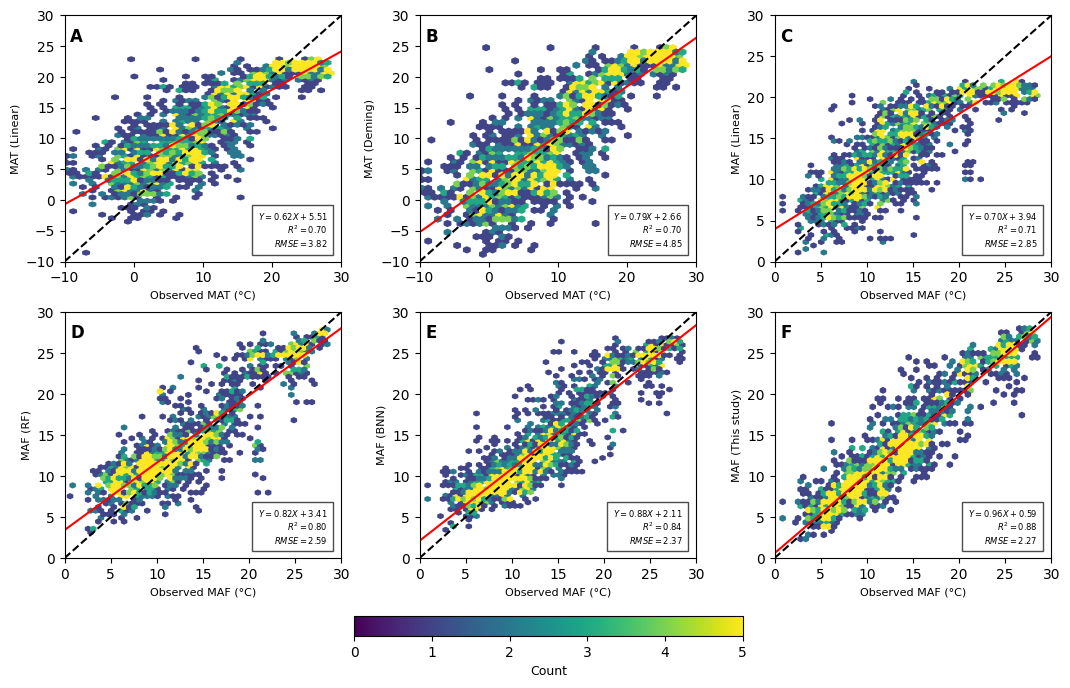

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
import matplotlib as mpl

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

xls = pd.ExcelFile(
   "C:/Users/jie liang/gloabl soil brGDGT dataset - v2.xlsx"
)
df = pd.read_excel(xls, ' Temperature_Comparison')

df_clean = df.dropna(subset=[
    'MAT_worldclim', 'MATdeJonge', 'MATsoilNaaf',
    'MAF_WorldClim', 'MAF_linear', 'MAF-WC_FROG0',
    'MAFterr_soil.pred_BNN', 'newcal'
])

x_mat = df_clean['MAT_worldclim']
y_mat1 = df_clean['MATdeJonge']
y_mat2 = df_clean['MATsoilNaaf']

x_maf = df_clean['MAF_WorldClim']
y_maf1 = df_clean['MAF_linear']
y_maf2 = df_clean['MAF-WC_FROG0']
y_maf3 = df_clean['MAFterr_soil.pred_BNN']
y_maf4 = df_clean['newcal']


def plot_with_regression(
    ax, x, y, x_label, y_label, panel_label, lim
):

    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    hb = ax.hexbin(
        x, y,
        gridsize=50,
        cmap='viridis',
        mincnt=1,
        vmin=0,
        vmax=5
    )

    x_fit = np.array(lim)
    y_fit = slope * x_fit + intercept

    y_pred = slope * x + intercept
    residuals = y - y_pred

    rmse = np.sqrt(np.mean(residuals ** 2))

    ss_res = np.sum(residuals ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r2 = 1 - ss_res / ss_tot

    ax.plot(lim, lim, 'k--', lw=1.5)
    ax.plot(x_fit, y_fit, 'r-', lw=1.5)

    ax.set_xlim(lim)
    ax.set_ylim(lim)

    ax.set_xlabel(x_label, fontsize=8)
    ax.set_ylabel(y_label, fontsize=8)

    textstr = (
        f'$Y = {slope:.2f}X + {intercept:.2f}$\n'
        f'$R^2 = {r2:.2f}$\n'
        f'$RMSE = {rmse:.2f}$'
    )

    ax.text(
        0.95, 0.05, textstr,
        transform=ax.transAxes,
        fontsize=6,
        ha='right', va='bottom',
        bbox=dict(facecolor='white', alpha=0.7)
    )

    ax.text(
        0.02, 0.95, panel_label,
        transform=ax.transAxes,
        fontsize=12, fontweight='bold',
        va='top'
    )

    return hb


fig, axs = plt.subplots(2, 3, figsize=(10.8, 7.2))

hb1 = plot_with_regression(
    axs[0, 0], x_mat, y_mat1,
    'Observed MAT (°C)', 'MAT (Linear)',
    'A', lim=(-10, 30)
)

hb2 = plot_with_regression(
    axs[0, 1], x_mat, y_mat2,
    'Observed MAT (°C)', 'MAT (Deming)',
    'B', lim=(-10, 30)
)

hb3 = plot_with_regression(
    axs[0, 2], x_maf, y_maf1,
    'Observed MAF (°C)', 'MAF (Linear)',
    'C', lim=(0, 30)
)

hb4 = plot_with_regression(
    axs[1, 0], x_maf, y_maf2,
    'Observed MAF (°C)', 'MAF (RF)',
    'D', lim=(0, 30)
)

hb5 = plot_with_regression(
    axs[1, 1], x_maf, y_maf3,
    'Observed MAF (°C)', 'MAF (BNN)',
    'E', lim=(0, 30)
)

hb6 = plot_with_regression(
    axs[1, 2], x_maf, y_maf4,
    'Observed MAF (°C)', 'MAF (This study)',
    'F', lim=(0, 30)
)

cbar = fig.colorbar(
    hb1, ax=axs,
    orientation='horizontal',
    fraction=0.035,
    pad=-0.22
)
cbar.set_label('Count', fontsize=9)
cbar.set_ticks(np.arange(0, 6, 1))

plt.rc('font', family='serif')
plt.tight_layout()
plt.show()
